In [ ]:
%pip install emoji
%pip install imbalanced-learn
%pip install contractions
%pip install inflect
%pip install transformers
%pip install spacy
%pip install readability
%pip install textblob
%pip install liwc
%pip install textstat
%pip install gensim

In [ ]:
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import pos_tag
import emoji
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imblearn
from collections import Counter
from wordcloud import WordCloud
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Ссылка для загрузки датасета: https://zenodo.org/records/1323873#.X3na6WgzY2w

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/mbti_full_pull.csv')
data.head()

,author_flair_text,body,subreddit
0,INTJ,Knowing you're in INTJ is a tool for you to us...,intj
1,INTJ,You are truly an enlightened mastermind.,intj
2,"INFJ, 26F",You should :) it will help if you have a down ...,infj
3,INTP,I watch a bit of everything (including hentai)...,INTP
4,INTJ,I don't know if I would count this as a pet pe...,intj


In [ ]:
data.drop(columns=["subreddit"], inplace=True)
data.rename(columns={"author_flair_text": "type", "body": "posts"}, inplace=True)

In [ ]:
pattern = r'([IiEe][NnSs][TtFf][JjPp])'
data['type'] = data['type'].str.extract(pattern)
data['type'] = data['type'].str.upper()
data.dropna(subset=['type'], inplace=True)


In [ ]:
data.describe()

,type,posts
count,1794016,1793961
unique,16,1746610
top,INTP,Yes.
freq,474183,677


In [ ]:
data1 = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/mbti_personalitycafe.csv')
data3 = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/twitter_MBTI.csv')
#dataCeleb = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/MBTI celeb.csv')

In [ ]:
#print(dataCeleb.isna().sum())
#dataCeleb.head()

name                               0
personality                        0
total votes                        0
first letter votes percentage      0
second letter votes percentage     0
third letter votes percentage      0
fourth letter votes percentage     0
first function                     0
second function                    0
third function                     0
fourth function                    0
Instinctual_Variant_type           0
Tritype_type                       0
Socionics_type                     0
Big5_type                          0
Attitudinal_Psyche_type            0
Temperaments_type                  0
fourletters_type_votes             0
Instinctual_Variant_total_votes    0
Tritype_total_votes                0
Socionics_total_votes              0
Big5_total_votes                   0
Attitudinal_Psyche_total_votes     0
Temperaments_total_votes           0
Instinctual_Variant_type_votes     0
Tritype_type_votes                 0
Socionics_type_votes               0
B

,name,personality,total votes,first letter votes percentage,second letter votes percentage,third letter votes percentage,fourth letter votes percentage,first function,second function,third function,...,Socionics_total_votes,Big5_total_votes,Attitudinal_Psyche_total_votes,Temperaments_total_votes,Instinctual_Variant_type_votes,Tritype_type_votes,Socionics_type_votes,Big5_type_votes,Attitudinal_Psyche_type_votes,Temperaments_type_votes
0,Kim Kardashian,istj,1289,80%,97%,44%,86%,Si,Te,Fi,...,57,38,16,64,50,44,25,22,8,35
1,Sigmund Freud,istj,1128,95%,58%,90%,88%,Si,Te,Fi,...,79,41,39,68,59,38,52,35,25,54
2,Irene (Red Velvet),istj,964,97%,79%,90%,98%,Si,Te,Fi,...,42,75,22,104,91,53,29,41,13,90
3,Tzuyu (TWICE),istj,910,99%,97%,71%,54%,Si,Te,Fi,...,40,63,17,121,90,51,33,40,10,112
4,Moriah Rose Pereira (Poppy),istj,857,99%,59%,80%,77%,Si,Te,Fi,...,42,28,14,64,56,40,23,23,8,45


In [ ]:
#dataCeleb.drop(columns=list(dataCeleb.columns)[2::],inplace=True)
#dataCeleb['personality'] = dataCeleb['personality'].str.upper()

Последний датасет используем для скрэпинга цитат знаменитостей

In [ ]:
%pip install requests beautifulsoup4
import requests
from bs4 import BeautifulSoup

In [ ]:
def scrape_quotes_for_types(df, max_quotes=10):
    dfs = []

    for index, row in df.iterrows():
        mbti_type = row['personality']
        celebrity_name = row['name']
        url = f"https://www.goodreads.com/quotes/search?q={celebrity_name}"
        response = requests.get(url)

        if response.status_code == 200:
            soup = BeautifulSoup(response.content, 'html.parser')
            quote_elements = soup.find_all("div", class_="quote")

            filtered_quotes = []
            for quote_element in quote_elements:
                quote_text = quote_element.find("div", class_="quoteText").text.strip()
                quote_author = quote_element.find("span", class_="authorOrTitle").text.strip()
                if celebrity_name.lower() in quote_author.lower():
                    filtered_quotes.append(quote_text)
                if len(filtered_quotes) > max_quotes:
                    break

            df = pd.DataFrame({'type': [mbti_type]*len(filtered_quotes), 'posts': filtered_quotes})
            dfs.append(df)

    result_df = pd.concat(dfs, ignore_index=True)
    return result_df


In [ ]:
resultCeleb = scrape_quotes_for_types(dataCeleb)

In [ ]:
resultCeleb1 = resultCeleb.copy()

def extract_quote(text):
    match = re.match(r'^“(.+?)”', text)
    if match:
        return match.group(1)
    else:
        return None

resultCeleb1['posts'] = resultCeleb1['posts'].apply(extract_quote)


In [ ]:
resultCeleb1.describe()

,type,posts
count,5358,5357
unique,16,5357
top,INFJ,Have courage for the great sorrows of life and...
freq,525,1


In [ ]:
resultCeleb1.drop_duplicates(subset=['posts'], keep='first', inplace=True)
resultCeleb1.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/resultceleb.csv', index=False)

In [ ]:
data3.columns

Index(['Unnamed: 0', 'text', 'label'], dtype='object')

In [ ]:
data3.drop(columns=['Unnamed: 0'], inplace=True)
data3.rename(columns={"label": "type", "text": "posts"}, inplace=True)

In [ ]:
pattern = r'([IiEe][NnSs][TtFf][JjPp])'
data3['type'] = data3['type'].str.extract(pattern)
data3['type'] = data3['type'].str.upper()
data3.dropna(subset=['type'], inplace=True)

In [ ]:
resultCeleb = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/resultceleb.csv')
data = pd.concat([data, data1, data3, resultCeleb], ignore_index=True)
print(data.isnull().sum())
data.dropna(subset=['posts'], inplace=True)
data.drop_duplicates(subset=['posts'], keep='first', inplace=True)
data = data[data['posts'].apply(lambda x: len(x.split()) >= 20)]
data.describe()

type      0
posts    56
dtype: int64


,type,posts
count,1091205,1091205
unique,16,1091205
top,INTP,Knowing you're in INTJ is a tool for you to us...
freq,274380,1


In [ ]:
from sklearn.utils import shuffle
data = shuffle(data).reset_index()
data.tail()

,index,type,posts
1091200,867958,INTJ,It's very rare that I don't complete a task. T...
1091201,1589193,INTP,I can enumerate a list of reasons but I think ...
1091202,1389269,INTJ,Why would it be an imperfection? Everyone's di...
1091203,724462,INTJ,that's why all the fanfiction exists where he ...
1091204,907245,ENTJ,You're a new guy in your office? There's a cou...


In [ ]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
# пронумируем типы
data['encoded_type'] = label_encoder.fit_transform(data['type'])

In [ ]:
def get_types(row):
    type_mapping = {'I/E': {'I': 1, 'E': 0}, 'N/S': {'N': 1, 'S': 0}, 'F/T': {'F': 1, 'T': 0}, 'J/P': {'J': 1, 'P': 0}}
    result = {}
    t = row['type']
    for code, mapping in type_mapping.items():
        if t[len(result)] not in mapping:
            print(f"{code}-{mapping.keys()} not found")
        else:
            result[code] = mapping[t[len(result)]]
    return pd.Series(result)

data = data.join(data.apply(lambda row: get_types(row), axis=1))

**1. Исследование датасета**

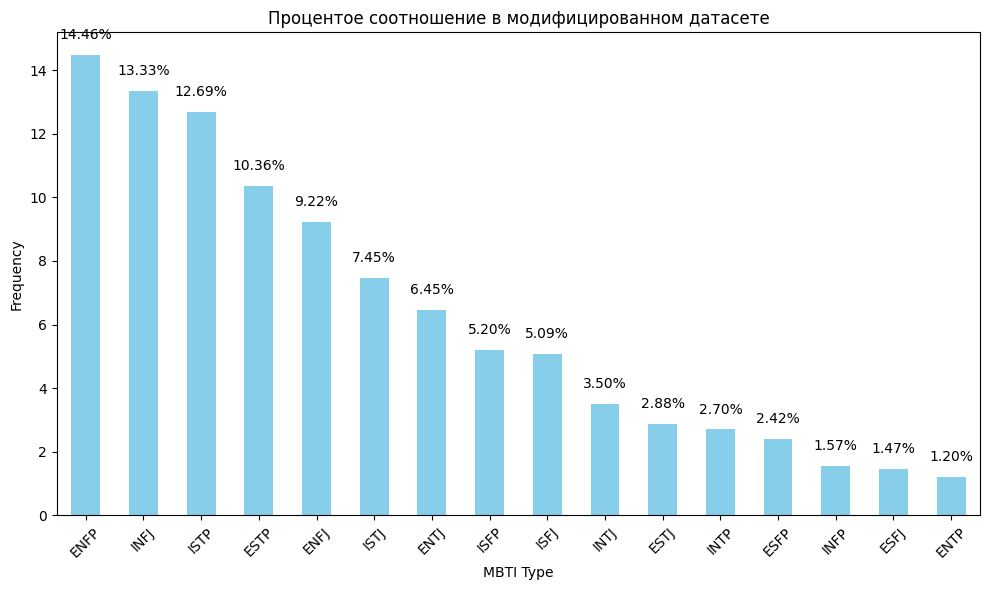

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

df = datacpy.copy()
type_counts = df['type'].value_counts()
total_count = type_counts.sum()
type_percentages = (type_counts / total_count) * 100

plt.figure(figsize=(10, 6))
bars = type_percentages.plot(kind='bar', color='skyblue')
plt.title('Процентое соотношение в модифицированном датасете')
plt.xlabel('MBTI Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

for i, percentage in enumerate(type_percentages):
    plt.text(i, percentage + 0.5, f'{percentage:.2f}%', ha='center')

plt.tight_layout()
plt.show()

Дополнительно посмотрим распределение между шкалами

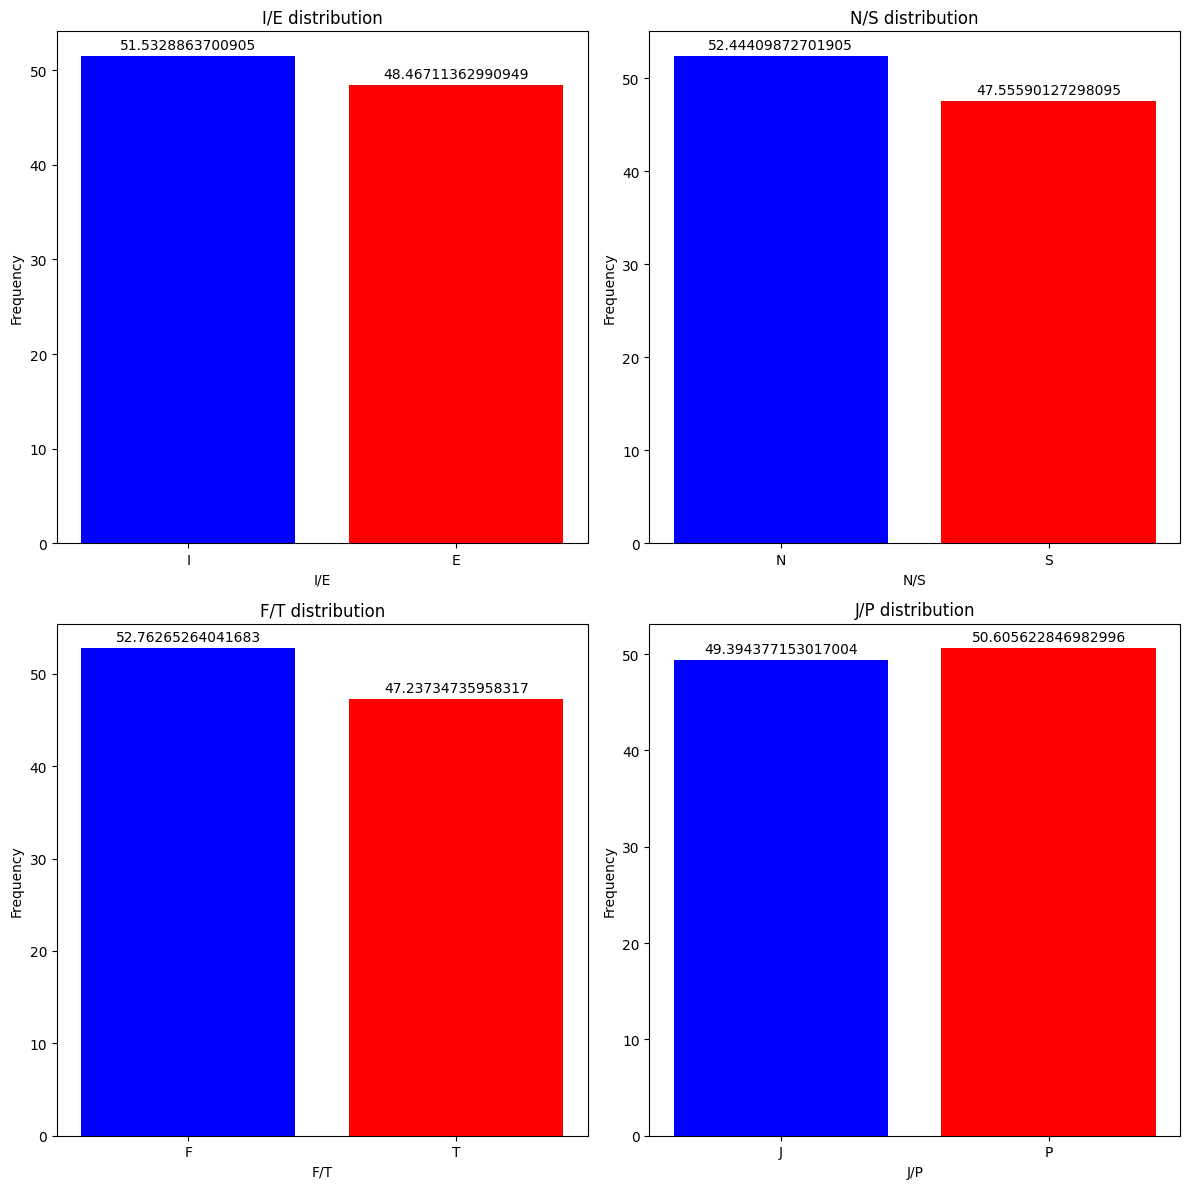

In [ ]:
scale_mappings = {
    'I/E': {'I': ['INTJ', 'INFJ', 'ISTJ', 'ISFJ', 'INTP', 'INFP', 'ISFP', 'ISTP'],
            'E': ['ENTJ', 'ENFJ', 'ESTJ', 'ESFJ', 'ENTP', 'ENFP', 'ESTP', 'ESFP']},
    'N/S': {'N': ['INFJ', 'INTJ', 'ENFP', 'ENTP', 'INFP', 'ENFJ', 'INTP', 'ENTJ'],
            'S': ['ISTP', 'ISFP', 'ESTP', 'ESFP', 'ESTJ', 'ESFJ', 'ISFJ', 'ISTJ']},
    'F/T': {'F': ['INFP', 'ENFP', 'ENFJ', 'INFJ', 'ISFP', 'ESFP', 'ESFJ', 'ISFJ'],
            'T': ['INTJ', 'ENTJ', 'ENTP', 'INTP', 'ISTJ', 'ESTJ', 'ESTP', 'ISTP']},
    'J/P': {'J': ['INFJ', 'ENFJ', 'INTJ', 'ENTJ', 'ISFJ', 'ESFJ', 'ISTJ', 'ESTJ'],
            'P': ['INFP', 'ENFP', 'INTP', 'ENTP', 'ISFP', 'ESFP', 'ISTP', 'ESTP']}
}

type_counts = df['type'].value_counts(normalize=True)

df['Frequency'] = df['type'].map(type_counts) * 100

mbti_data1 = {
    'Type': list(df['type'].unique()),
    'Frequency': list(df.Frequency.unique())
}
mbti_df1 = pd.DataFrame(mbti_data1)

scale_distributions = {}
for scale, mappings in scale_mappings.items():
    scale_distribution = {}
    for value, types in mappings.items():
        scale_distribution[value] = mbti_df1[mbti_df1['Type'].isin(types)]['Frequency'].sum()
    scale_distributions[scale] = scale_distribution


fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, (scale, distribution) in enumerate(scale_distributions.items()):
    ax = axes[i // 2, i % 2]
    bars1 = ax.bar(distribution.keys(), distribution.values(), color=['blue', 'red'])
    ax.set_title(scale + ' distribution')
    ax.set_xlabel(scale)
    ax.set_ylabel('Frequency')
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.show()

Статистические данные с сайта: https://personalitymax.com/personality-types/population-gender/

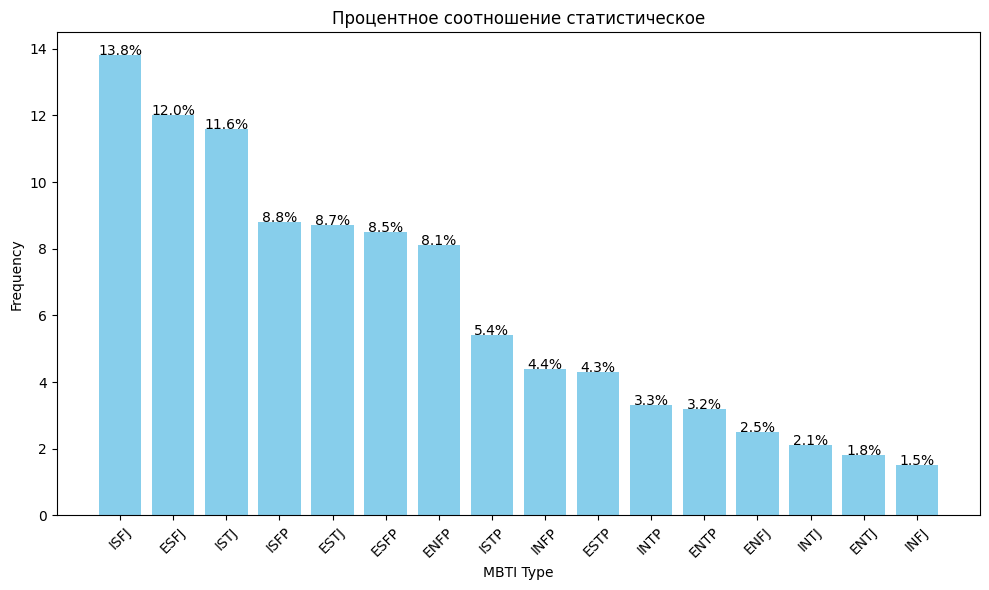

In [ ]:
mbti_data = {
    'Type': ['INTJ','INTP','ENTJ','ENTP','INFJ','INFP','ENFJ',
             'ENFP','ISTJ','ISFJ','ESTJ','ESFJ','ISTP','ISFP','ESTP','ESFP'],
    'Frequency': [2.1, 3.3, 1.8, 3.2, 1.5, 4.4, 2.5, 8.1, 11.6, 13.8, 8.7, 12,
                  5.4, 8.8, 4.3, 8.5]}

statdf = pd.DataFrame(mbti_data)
statdf.sort_values(by='Frequency', ascending=False, inplace=True)

plt.figure(figsize=(10, 6))
bars = plt.bar(statdf['Type'], statdf['Frequency'], color='skyblue')
plt.title('Процентное соотношение статистическое')
plt.xlabel('MBTI Type')
plt.ylabel('Frequency')
plt.xticks(rotation=45)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center')

plt.tight_layout()
plt.show()

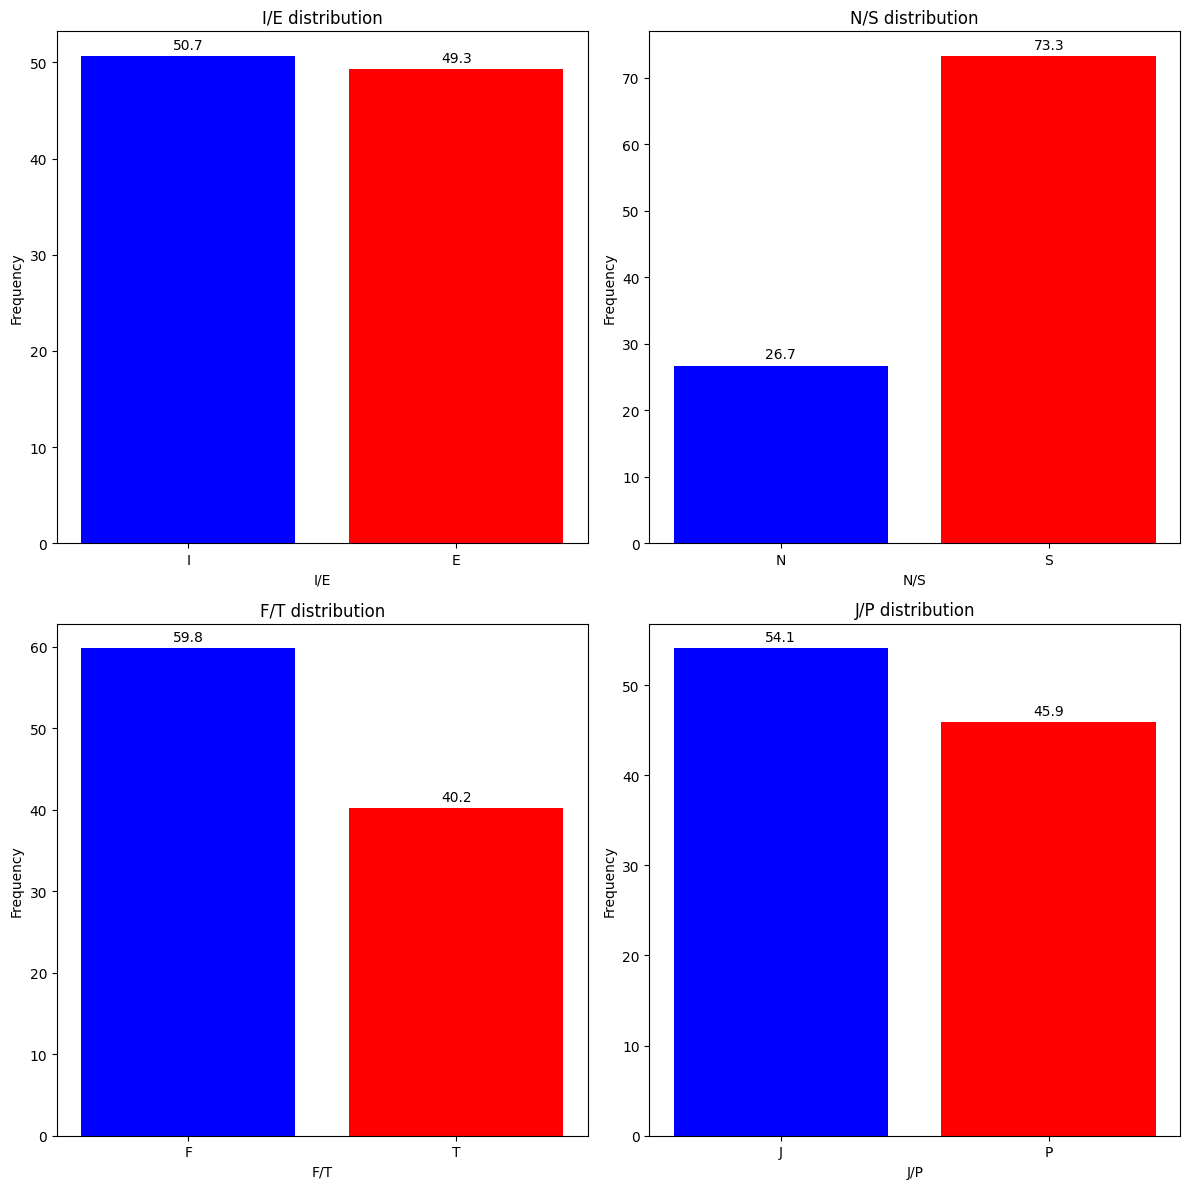

In [ ]:
# статистическое с сайта
mbti_data_scales = {
    'I/E': (50.7, 49.3), 'N/S': (26.7, 73.3),
    'F/T': (59.8, 40.2), 'J/P': (54.1, 45.9)
}

scale_distributions = {
    'I/E': {'I': mbti_data_scales['I/E'][0], 'E': mbti_data_scales['I/E'][1]},
    'N/S': {'N': mbti_data_scales['N/S'][0], 'S': mbti_data_scales['N/S'][1]},
    'F/T': {'F': mbti_data_scales['F/T'][0], 'T': mbti_data_scales['F/T'][1]},
    'J/P': {'J': mbti_data_scales['J/P'][0], 'P': mbti_data_scales['J/P'][1]}
}

fig, axes = plt.subplots(2, 2, figsize=(12, 12))
for i, (scale, distribution) in enumerate(scale_distributions.items()):
    ax = axes[i // 2, i % 2]
    bars1 = ax.bar(distribution.keys(), distribution.values(), color=['blue', 'red'])
    ax.set_title(scale + ' distribution')
    ax.set_xlabel(scale)
    ax.set_ylabel('Frequency')
    for bar in bars1:
        height = bar.get_height()
        ax.annotate(f'{height}', xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3), textcoords='offset points', ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [ ]:
merged_df = pd.merge(left=statdf, right=type_percentages, how='inner', left_on='Type', right_index=True)
merged_df.rename(columns={'type': 'Dataset %'}, inplace=True)
print("Сравнение первоначального распределения и статистического")
print(merged_df)

Сравнение первоначального распределения и статистического
    Type  Frequency      count
9   ISFJ       13.8   0.519792
11  ESFJ       12.0   0.162847
8   ISTJ       11.6   1.042151
13  ISFP        8.8   0.665136
10  ESTJ        8.7   0.425310
15  ESFP        8.5   0.396901
7   ENFP        8.1   5.725597
12  ISTP        5.4   3.383141
5   INFP        4.4  10.559519
14  ESTP        4.3   2.322937
1   INTP        3.3  25.144680
3   ENTP        3.2  11.499947
6   ENFJ        2.5   1.214437
0   INTJ        2.1  21.307362
2   ENTJ        1.8   2.789577
4   INFJ        1.5  12.840667


In [ ]:
#data.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/beforedeleting_data.csv', index=False)

In [ ]:
import pandas as pd
data_cpy = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/beforedeleting_data.csv',lineterminator='\n')
data_cpy.head()

,index,type,posts,encoded_type,I/E,N/S,F/T,J/P
0,1678477,ISTJ,"Well, it isn't decided by a Shadow Council. Bi...",14,1,0,0,1
1,1324169,INFP,I love quirky indie games like Thomas Was Alon...,9,1,1,1,0
2,29119,INFJ,"As an INFJ about to marry an ENTP, I'm throwin...",8,1,1,1,1
3,1111546,ENFP,What's it like to not have Ne (PoLR Ne)? It's ...,1,0,1,1,0
4,704544,INTJ,"Love is not an emotion, not primary nor second...",10,1,1,0,1


В описании одного из датасетов сказано, что в одной строке может содержаться сразу много постов одного автора, разделенных ||.
Имеет смысл разнести их по отдельным строкам, т.к. дальше будет анализ эмоционального окраса, кроме того, посты, склеенные таким образом, будут слишком длинными

In [ ]:
contains_pipe = data_cpy['posts'].str.contains(r'\|{2,3}')
count_with_pipe = contains_pipe.sum()
print(f"Number of posts that contain '||': {count_with_pipe}")

Number of posts that contain '||': 16391


In [ ]:
data_cpy['posts'] = data_cpy['posts'].str.split(r'\|{2,3}')
data_cpy = data_cpy.explode('posts')
data_cpy.reset_index(drop=True, inplace=True)

In [ ]:
data_cpy['posts'].describe()

count     2560608
unique    2516346
top              
freq        11128
Name: posts, dtype: object

In [ ]:
data_cpy.drop_duplicates(subset=['posts'], keep='first', inplace=True)

Посмотрим, как распределены посты разных типов по длине

In [ ]:
def calculate_post_length(post):
    return len(post.split())

data_cpy['post_length'] = data_cpy['posts'].apply(calculate_post_length)
ranges = [(0, 20),(20,30), (30, 50), (50, 80), (80, 100), (100, 130), (130, 180), (180, 250), (250, 350), (350, 500), (510, 1000),(1500,float('inf'))]
post_length_counts_by_type = {}

for mbti_type, group in data_cpy.groupby('type'):
    post_length_counts_by_type[mbti_type] = {str(range_): 0 for range_ in ranges}
    for range_ in ranges:
        lower, upper = range_
        count = group[group['post_length'].between(lower, upper, inclusive='left')].shape[0]
        post_length_counts_by_type[mbti_type][str(range_)] = count

for mbti_type, counts in post_length_counts_by_type.items():
    print(f"MBTI Type: {mbti_type}")
    for range_, count in counts.items():
        print(f"  Posts in range {range_}: {count}")


MBTI Type: ENFJ
  Posts in range (0, 20): 58212
  Posts in range (20, 30): 15676
  Posts in range (30, 50): 8576
  Posts in range (50, 80): 2475
  Posts in range (80, 100): 1045
  Posts in range (100, 130): 995
  Posts in range (130, 180): 1003
  Posts in range (180, 250): 699
  Posts in range (250, 350): 450
  Posts in range (350, 500): 275
  Posts in range (510, 1000): 225
  Posts in range (1500, inf): 13
MBTI Type: ENFP
  Posts in range (0, 20): 90426
  Posts in range (20, 30): 32415
  Posts in range (30, 50): 34517
  Posts in range (50, 80): 12799
  Posts in range (80, 100): 4990
  Posts in range (100, 130): 4927
  Posts in range (130, 180): 4676
  Posts in range (180, 250): 3088
  Posts in range (250, 350): 1844
  Posts in range (350, 500): 982
  Posts in range (510, 1000): 473
  Posts in range (1500, inf): 7
MBTI Type: ENTJ
  Posts in range (0, 20): 34478
  Posts in range (20, 30): 14259
  Posts in range (30, 50): 13980
  Posts in range (50, 80): 6114
  Posts in range (80, 100): 

In [ ]:
from sklearn.utils import resample

min_length = 40
max_length = 500
dominant_types = ['INTP', 'INTJ', 'INFJ', 'ENTP', 'INFP','ENFP','INFJ']

deletion_percentages = {'INTP': 1,  'INTJ': 1,  'INFJ': 0.9, 'ENTJ':0.6,
                        'ENTP': 1, 'INFP': 1, 'ENFP': 0.6, 'ISTP': 0.3}

target_distribution = {
    'I/E': (51.0, 49.0),
    'N/S': (44.0, 56.0),
    'F/T': (58.0, 42.0),
    'J/P': (55.0, 45.0)}

datacpy = data_cpy[(data_cpy['post_length'] >= min_length) & (data_cpy['post_length'] <= max_length)]

for mbti_type, percentage_to_delete in deletion_percentages.items():
    dominant_posts = datacpy[(datacpy['type'] == mbti_type) & ((datacpy['post_length'] <= 250) | (datacpy['post_length'] >= 300))]
    num_to_delete = int(len(dominant_posts) * percentage_to_delete)
    posts_to_delete = dominant_posts.sample(n=num_to_delete, random_state=42)
    datacpy = datacpy.drop(posts_to_delete.index)

def resample_data(df, scale, target_dist):
    group1 = df[df[scale] == 1]
    group2 = df[df[scale] == 0]

    total_samples = len(df)
    target_size_group1 = int((target_dist[0] / 100) * total_samples)
    target_size_group2 = int((target_dist[1] / 100) * total_samples)

    group1_resampled = resample(group1, replace=False,  # Sampling without replacement
                                n_samples=min(target_size_group1, len(group1)),
                                random_state=42)
    group2_resampled = resample(group2, replace=False,  # Sampling without replacement
                                n_samples=min(target_size_group2, len(group2)),
                                random_state=42)

    balanced_data = pd.concat([group1_resampled, group2_resampled]).drop_duplicates()  # Remove duplicates

    return balanced_data


def resample_data_old(df, scale, target_dist):
    group1 = df[df[scale] == 1]
    group2 = df[df[scale] == 0]

    total_samples = len(df)
    target_size_group1 = int((target_dist[0] / 100) * total_samples)
    target_size_group2 = int((target_dist[1] / 100) * total_samples)

    group1_resampled = resample(group1, replace=len(group1) < target_size_group1,
                                n_samples=target_size_group1, random_state=42)
    group2_resampled = resample(group2, replace=len(group2) < target_size_group2,
                                n_samples=target_size_group2, random_state=42)

    balanced_data = pd.concat([group1_resampled, group2_resampled])

    return balanced_data


for scale, target_dist in target_distribution.items():
    datacpy = resample_data(datacpy, scale, target_dist)

# Verify the final distribution after resampling
for scale in target_distribution:
    scale_count = datacpy[scale].value_counts(normalize=True) * 100
    print(f"{scale} distribution after resampling: {scale_count.to_dict()}")



I/E distribution after resampling: {1: 51.5328863700905, 0: 48.4671136299095}
N/S distribution after resampling: {1: 52.44409872701905, 0: 47.55590127298095}
F/T distribution after resampling: {1: 52.76265264041684, 0: 47.23734735958317}
J/P distribution after resampling: {0: 50.605622846983, 1: 49.394377153017}


In [ ]:
datacpy['posts'].count()

80991

In [ ]:
datacpy['post_length'].describe()

count    80991.000000
mean       124.309738
std         92.832173
min         40.000000
25%         53.000000
50%         84.000000
75%        173.000000
max        500.000000
Name: post_length, dtype: float64

In [ ]:
datacpy.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/balanced_data1.csv', index=False)

**2. Обработка текста**

In [ ]:
%pip install emoji
%pip install imbalanced-learn
%pip install contractions
%pip install inflect
%pip install transformers
%pip install spacy
%pip install textacy
%pip install readability
%pip install textblob
%pip install textstat
%pip install gensim

In [ ]:
from transformers import pipeline
from functools import partial
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import textacy
from textacy import text_stats as ts
from textacy import preprocessing as prep
import re
import unicodedata
import imblearn
import gensim.downloader as api
from emoji import demojize
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import contractions
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
import emoji
from collections import Counter
from wordcloud import WordCloud
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


Выделим следующие признаки:


местоимения (1, 2, 3 лица, их частота)

использование passive voice

использование direct/indirect object

среднюю длину предложений

аналитичность текста (см. метрики)

эмоциональный посыл: посмотреть какие эмоции учитывать в первую очередь

Далее пример вычисления весов глодально для всего датасета (т.к. буду делить исходный датасет на несколько частей и их отдельно обрабатывать, но веса должны быть гобальными чтобы не потерять важность каких-то слов)

In [ ]:
def replace_mbti(text):
    mbti_types = [
    'INTJ', 'INTP', 'ENTJ', 'ENTP',
    'INFJ', 'INFP', 'ENFJ', 'ENFP',
    'ISTJ', 'ISFJ', 'ESTJ', 'ESFJ',
    'ISTP', 'ISFP', 'ESTP', 'ESFP',
    'INTJS', 'INTPS', 'ENTJS', 'ENTPS',
    'INFJS', 'INFPS', 'ENFJS', 'ENFPS',
    'ISTJS', 'ISFJS', 'ESTJS', 'ESFJS',
    'ISTPS', 'ISFPS', 'ESTPS', 'ESFPS']
    mbti_pattern = '|'.join(mbti_types)
    pattern = re.compile(r'\b(' + mbti_pattern + r')\b', re.IGNORECASE)
    replaced_text = pattern.sub('MBTI', text)
    return replaced_text

def replace_emojis_with_words(text):
    text = demojize(text, delimiters=(" ", " "))
    text = text.replace(":", "").replace("_", " ")
    return text

def create_preprocessing_pipeline():
    preprocessing_functions = [
        prep.normalize.unicode,
        prep.normalize.bullet_points,
        prep.normalize.hyphenated_words,
        prep.normalize.quotation_marks,
        prep.normalize.whitespace,
        prep.remove.accents,
        prep.remove.brackets,
        prep.remove.html_tags,
        prep.replace.urls,
        prep.replace.user_handles,
        prep.remove.punctuation,
        prep.replace.currency_symbols,
        prep.replace.emails,
        prep.replace.hashtags,
        prep.replace.numbers,
        prep.replace.phone_numbers,
        replace_mbti,
        replace_emojis_with_words,]

    preprocessing_pipeline = prep.pipeline.make_pipeline(*preprocessing_functions)
    return preprocessing_pipeline

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/balanced_data1.csv',lineterminator='\n')
data.head()

,index,type,posts,encoded_type,I/E,N/S,F/T,J/P,post_length
0,328482,ISFJ,"&gt; And even when you settle on a type, you f...",12,1,0,1,1,180
1,1465848,INFJ,"I'm skinny and lazy, i want to be fit and acti...",8,1,1,1,1,58
2,1794554,ENFJ,"I think its normal, happens to me a lot actual...",0,0,1,1,1,41
3,439065,INFJ,I don't know if it necessarily works better th...,8,1,1,1,1,55
4,1417771,ISFJ,"Why do you feel that the description of ""Fe"" d...",12,1,0,1,1,68


После очистки текста станет понятно, можно ли что-то ещё удалить (если совсем длина постов будет маленькой в очищенном тексте)

In [ ]:
nlp = spacy.load("en_core_web_sm")

def clean_text(input_text):
  cleaned_tokens = []
  try:
    input_text = re.sub(r'\|', '', input_text)
    input_text = contractions.fix(input_text)
    pipeline = create_preprocessing_pipeline()
    input_text = pipeline(input_text).lower()
    input_text = re.sub(r'\W+', ' ', input_text)

    doc = nlp(input_text)

    for token in doc:
          # тут очищаем ещё  от стоп-слов и для вектора используем cleaned_tokens
          if not (token.is_punct or token.is_space or token.is_stop or token.is_digit):
              cleaned_tokens.append(token.lemma_)
  except Exception as e:
    print(input_text)
    print(e)
  return ' '.join(cleaned_tokens)

In [ ]:
data['cleaned_text'] = data['posts'].apply(lambda x: clean_text(x))
data = data[data['cleaned_text'] != '']
#data.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/allcleaned_data.csv', index=False)
data.head()

İstanbul bilhassa 19. Yüzyılda göçmen İtalyanlarla doluydu. Beyoğlu'nun birçok binası İtalyan ustaların ve onların yetiştirdiği Rumların eseridir. Şehirde bu maddi kalıntıları dışında birçok dil ve adet kalıntısı da vardır. Gemicilik terimleri dışında, İstanbul ve İzmir argosu da İtalyanca deyimlerle doludur. "Mantenuta" kelimesi, kapatma-metres karşılığı olarak "montinata" veya "manita" diyr geçer. "Alırım façanı aşağı" diyen adamların bu kelimenin "faccia"dan geldiğini bildiklerini sanmayız. "Bu işin raconu böyledir" diyenler, kelimenin İtalyanca "raggione" den geldiğini belki bilmezler. Zaten argoda kaynağı bilmek diye bir sorun yoktur.
string index out of range


,index,type,posts,encoded_type,I/E,N/S,F/T,J/P,post_length,cleaned_text
0,328482,ISFJ,"&gt; And even when you settle on a type, you f...",12,1,0,1,1,180,settle type feel like act fit kind mould feel ...
1,1465848,INFJ,"I'm skinny and lazy, i want to be fit and acti...",8,1,1,1,1,58,skinny lazy want fit active oh ask try take te...
2,1794554,ENFJ,"I think its normal, happens to me a lot actual...",0,0,1,1,1,41,think normal happen lot actually date girl fin...
3,439065,INFJ,I don't know if it necessarily works better th...,8,1,1,1,1,55,know necessarily work well questionnaire detai...
4,1417771,ISFJ,"Why do you feel that the description of ""Fe"" d...",12,1,0,1,1,68,feel description fe fit mind function work pai...


In [ ]:
mask_empty_posts = data['cleaned_text'].str.strip() == ""
data = data[~mask_empty_posts]

In [ ]:
data.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/allcleaned_data.csv', index=False)

Разбиваю на несколько частей и работаю с ними по отдельности, так как слишком большой объем датасета

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/allcleaned_data.csv',lineterminator='\n')
data.head()

,index,type,posts,encoded_type,I/E,N/S,F/T,J/P,post_length,cleaned_text
0,328482,ISFJ,"&gt; And even when you settle on a type, you f...",12,1,0,1,1,180,settle type feel like act fit kind mould feel ...
1,1465848,INFJ,"I'm skinny and lazy, i want to be fit and acti...",8,1,1,1,1,58,skinny lazy want fit active oh ask try take te...
2,1794554,ENFJ,"I think its normal, happens to me a lot actual...",0,0,1,1,1,41,think normal happen lot actually date girl fin...
3,439065,INFJ,I don't know if it necessarily works better th...,8,1,1,1,1,55,know necessarily work well questionnaire detai...
4,1417771,ISFJ,"Why do you feel that the description of ""Fe"" d...",12,1,0,1,1,68,feel description fe fit mind function work pai...


In [ ]:
df = data.copy()
total_records = len(df)
parts = 4
part_size = total_records // parts

part_num = 1
records_assigned = 0
part_data = []
part_datasets = {}

for index, row in df.iterrows():
    if records_assigned < part_size:
        part_data.append(row)
        records_assigned += 1
    else:
        part_df = pd.DataFrame(part_data)
        part_datasets[f'part_{part_num}'] = part_df
        part_num += 1
        records_assigned = 0
        part_data = []


if part_data:
    part_df = pd.DataFrame(part_data)
    part_datasets[f'part_{part_num}'] = part_df

for key, value in part_datasets.items():
    print(f"{key} size: {len(value)}")


part_1 size: 20246
part_2 size: 20246
part_3 size: 20246
part_4 size: 20243


In [ ]:
from transformers import pipeline

classifier = pipeline(task="text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None)

sentences = ["I am not having a great day"]

model_outputs = classifier(sentences)
print(model_outputs[0])

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/380 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.11M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/280 [00:00<?, ?B/s]

[{'label': 'disappointment', 'score': 0.4666951894760132}, {'label': 'sadness', 'score': 0.39849498867988586}, {'label': 'annoyance', 'score': 0.06806593388319016}, {'label': 'neutral', 'score': 0.05703023821115494}, {'label': 'disapproval', 'score': 0.044239308685064316}, {'label': 'nervousness', 'score': 0.014850745908915997}, {'label': 'realization', 'score': 0.014059904962778091}, {'label': 'approval', 'score': 0.0112674655392766}, {'label': 'joy', 'score': 0.006303396541625261}, {'label': 'remorse', 'score': 0.006221492309123278}, {'label': 'caring', 'score': 0.006029403302818537}, {'label': 'embarrassment', 'score': 0.0052654859609901905}, {'label': 'anger', 'score': 0.004981426056474447}, {'label': 'disgust', 'score': 0.004259029403328896}, {'label': 'grief', 'score': 0.0040021371096372604}, {'label': 'confusion', 'score': 0.003382918192073703}, {'label': 'relief', 'score': 0.0031405005138367414}, {'label': 'desire', 'score': 0.00282747158780694}, {'label': 'admiration', 'score'

In [ ]:
def truncate_text(text, max_length=500):
    return text[:max_length]

# результат в отдельные колонки
def unpack_sentiment(sentiment_list):
    sentiment_dict = {}

    for item in sentiment_list[0]:
          sentiment_dict[item['label']] = item['score']
    return sentiment_dict

In [ ]:
dataset1 = part_datasets["part_4"]
nan_count = dataset1.isnull().sum().sum()
print('Number of NaN values:', nan_count)

Number of NaN values: 0


Дальше классификация по эмоциям

In [ ]:
def classify_text(text):
    try:
        result = classifier(truncate_text(text))
        return result
    except Exception as e:
        print(f"Exception encountered while processing text: {text}\nError: {e}")
        return [[{}]]

In [ ]:
dataset1['sentiment'] = dataset1['posts'].apply(classify_text)
# 4
dataset1.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/sentiment_raw_data4.csv', index=False)

In [ ]:
import pandas as pd

dataset1 = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/sentiment_raw_data4.csv',lineterminator='\n')
dataset1.head()

,index,type,posts,encoded_type,I/E,N/S,F/T,J/P,post_length,cleaned_text,sentiment
0,1389447,ENFP,wow are you an intj or what? lol\nThe point of...,1,0,1,1,0,45,wow mbti lol point poem meaningless question h...,"[[{'label': 'amusement', 'score': 0.7800372838..."
1,968770,ISTP,"Atheist here, but after dating a Jewish woman ...",15,1,0,0,0,42,atheist date jewish woman respect religion exp...,"[[{'label': 'admiration', 'score': 0.838547289..."
2,1085705,ESTP,"He had mental illness, which as far as I know,...",7,0,0,0,0,47,mental illness far know study relation mbti ty...,"[[{'label': 'neutral', 'score': 0.711340487003..."
3,1670869,ENFP,THANKSGIVING! I flew down to the South to cele...,1,0,1,1,0,166,thanksgive fly south celebrate family lot chan...,"[[{'label': 'joy', 'score': 0.8521894812583923..."
4,1142154,ENFP,"Strong women, both mentally and physically. \...",1,0,1,1,0,59,strong woman mentally physically wife electric...,"[[{'label': 'admiration', 'score': 0.804942071..."


In [ ]:
data_types = dataset1['sentiment'].apply(type)
print("Unique data types in the column:", data_types.unique())

Unique data types in the column: [<class 'str'>]


In [ ]:
dataset1 = dataset1[dataset1['sentiment'] != '[[{}]]']
dataset1['sentiment'].describe()

count                                                 20243
unique                                                20242
top       [[{'label': 'neutral', 'score': 0.836393415927...
freq                                                      2
Name: sentiment, dtype: object

In [ ]:
import ast

def convert_string_to_nested_list(string):
    return ast.literal_eval(string)

dataset1['sentiment'] = dataset1['sentiment'].apply(convert_string_to_nested_list)

In [ ]:
dataset1_unpacked = dataset1['sentiment'].apply(unpack_sentiment)
dataset1_unpacked_df = pd.DataFrame(dataset1_unpacked.tolist())
dataset11 = pd.concat([dataset1.drop(columns=['sentiment']), dataset1_unpacked_df], axis=1)
dataset11.head()

,index,type,posts,encoded_type,I/E,N/S,F/T,J/P,post_length,cleaned_text,...,gratitude,relief,desire,pride,nervousness,sadness,caring,fear,grief,remorse
0,1389447,ENFP,wow are you an intj or what? lol\nThe point of...,1,0,1,1,0,45,wow mbti lol point poem meaningless question h...,...,0.002810,0.002627,0.001873,0.001518,0.001382,0.001342,0.001239,0.000940,0.000780,0.000705
1,968770,ISTP,"Atheist here, but after dating a Jewish woman ...",15,1,0,0,0,42,atheist date jewish woman respect religion exp...,...,0.023101,0.001856,0.000902,0.007042,0.000149,0.001003,0.003618,0.000524,0.000405,0.000467
2,1085705,ESTP,"He had mental illness, which as far as I know,...",7,0,0,0,0,47,mental illness far know study relation mbti ty...,...,0.000933,0.004820,0.002426,0.000476,0.014503,0.163309,0.017193,0.006902,0.004078,0.004040
3,1670869,ENFP,THANKSGIVING! I flew down to the South to cele...,1,0,1,1,0,166,thanksgive fly south celebrate family lot chan...,...,0.042919,0.016713,0.003838,0.009040,0.001456,0.001649,0.005154,0.000822,0.000844,0.000676
4,1142154,ENFP,"Strong women, both mentally and physically. \...",1,0,1,1,0,59,strong woman mentally physically wife electric...,...,0.004748,0.001998,0.001279,0.008339,0.000219,0.002159,0.007331,0.000615,0.000616,0.000523


In [ ]:
dataset11.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/sentiment_raw_data4.csv', index=False)

**3. Текстовый анализ**


In [ ]:
%pip install nltk
import nltk
nltk.download('wordnet')
from nltk.corpus import wordnet

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def get_synonyms(word):
    synonyms = set()
    for syn in wordnet.synsets(word):
        for lemma in syn.lemmas():
            synonyms.add(lemma.name())
    return synonyms

def add_synonyms_to_set(word_set):
    updated_set = set(word_set)
    for word in word_set:
        synonyms = get_synonyms(word)
        updated_set.update(synonyms)
    return updated_set

word_set = {"happy", "sad", "good"}
word_set_with_synonyms = add_synonyms_to_set(word_set)
print("Words with synonyms:", word_set_with_synonyms)


Words with synonyms: {'pitiful', 'skillful', 'deplorable', 'thoroughly', 'practiced', 'expert', 'well', 'lamentable', 'just', 'dependable', 'commodity', 'soundly', 'beneficial', 'felicitous', 'trade_good', 'skilful', 'sorry', 'distressing', 'effective', 'estimable', 'respectable', 'glad', 'upright', 'sound', 'well-chosen', 'ripe', 'salutary', 'in_effect', 'unspoiled', 'sad', 'full', 'goodness', 'honorable', 'near', 'adept', 'safe', 'serious', 'dear', 'unspoilt', 'happy', 'secure', 'good', 'undecomposed', 'honest', 'right', 'proficient', 'in_force'}


Добавляем синонимы

In [ ]:
first_singular_words = {'i', 'me', 'my', 'mine'}
first_plural_words = {'we', 'us', 'our', 'ours'}
third_second_words = {'he', 'she', 'it', 'her', 'hers', 'him', 'his', 'its'
                      'they', 'their','theirs', 'them', 'you', 'yours'}

strong_words = {'must', 'always', 'never', 'undeniably', 'unquestionably',
                'definitely', 'absolutely', 'absolute', 'utterly', 'demanded','precisely',
                'essential', 'necessity', 'necessary', 'obligatory', 'exact', 'exactly',
                'required', 'mandatary', 'mandate', 'mandatory',  'critical', 'vital',
                'clearly', 'clear', 'obviously', 'obvious', 'constantly'}

weak_words = {'may', 'might', 'maybe', 'can', 'could', 'would', 'believably',
              'occasionally', 'sometimes','unsure', 'uncertain', 'incertain',
              'probably', 'likely','possibly', 'possible', 'perhaps', 'mayhap', 'belike',
              'hope', 'guess','suppose', 'reckon', 'assume', 'consider', 'consideration',
              'hypothesis', 'hazard', 'approximate','condition'}

nlp = spacy.load("en_core_web_sm")

def preprocess_text(input_text):
    try:
      input_text = contractions.fix(input_text)
      input_text = re.sub(r'[^\w\s.,?!]', '', input_text)

      doc = nlp(input_text)

      first_singular_count, first_plural_count, second_third_count = 0, 0, 0
      passive_voice_count, direct_objects_count, indirect_objects_count = 0, 0, 0
      cc_count, strong_count, weak_count = 0, 0, 0

      for token in doc:
          lemma = token.lemma_.lower()

          if lemma in first_singular_words:
              first_singular_count += 1
          elif lemma in first_plural_words:
              first_plural_count += 1
          elif lemma in third_second_words:
              second_third_count += 1
          elif lemma in strong_words:
              strong_count += 1
          elif lemma in weak_words:
              weak_count += 1

          if token.dep_ == 'dobj':
              direct_objects_count += 1
          elif token.dep_ == 'iobj':
              indirect_objects_count += 1
          elif token.dep_ == 'auxpass':
              passive_voice_count += 1
          elif token.dep_ in ['cc', 'mark', 'relcl']:
              cc_count += 1

      total_words = len(doc)
      # местоимения
      relative_first_singular = first_singular_count / total_words if total_words > 0 else 0
      relative_first_plural = first_plural_count / total_words if total_words > 0 else 0
      relative_second_third = second_third_count / total_words if total_words > 0 else 0

      # другие части речи
      pos_counts = ts.counts.pos(doc)
      verb_ratio = pos_counts['VERB'] / total_words if 'VERB' in pos_counts else 0
      noun_ratio = pos_counts['NOUN'] / total_words if 'NOUN' in pos_counts else 0
      adj_ratio = pos_counts['ADJ'] / total_words if 'ADJ' in pos_counts else 0

      # спец конструкции
      passive_voice = passive_voice_count / total_words if total_words > 0 else 0
      direct_object = direct_objects_count / total_words if total_words > 0 else 0
      indirect_object = indirect_objects_count / total_words if total_words > 0 else 0
      strong_words = strong_count / total_words if total_words > 0 else 0
      weak_words = weak_count / total_words if total_words > 0 else 0

      # читабельность
      treadability = ts.readability.flesch_kincaid_grade_level(doc)
      # лексическое разнообразие
      diversity = ts.diversity.mtld(doc)

      return {
          'nouns': noun_ratio,
          'adjectives': adj_ratio,
          'verbs': verb_ratio,
          'readability' : treadability,
          'diversity' : diversity,
          'first_singular': relative_first_singular,
          'first_plural': relative_first_plural,
          'second_third': relative_second_third,
          'passive_voice': passive_voice,
          'direct_objects': direct_object,
          'indirect_objects': indirect_object,
          'strong_words': strong_words,
          'weak_words': weak_words}

    except Exception as e:
        print(e)
        return {'nouns': np.nan,'adjectives': np.nan,'verbs': np.nan,
        'readability' : np.nan,'diversity' : np.nan,
        'first_singular': np.nan, 'first_plural': np.nan,'second_third': np.nan,
        'passive_voice': np.nan, 'direct_objects': np.nan,'indirect_objects': np.nan,
        'strong_words': np.nan, 'weak_words':np.nan}



def preprocess_dataframe(df):
    preprocessed_data = df['posts'].apply(lambda x: preprocess_text(x))
    df['verbs'] = preprocessed_data.apply(lambda x: x['verbs'])
    df['nouns'] = preprocessed_data.apply(lambda x: x['nouns'])
    df['adjectives'] = preprocessed_data.apply(lambda x: x['adjectives'])
    df['complexity'] = preprocessed_data.apply(lambda x: x['complexity'])
    df['readability'] = preprocessed_data.apply(lambda x: x['readability'])
    df['diversity'] = preprocessed_data.apply(lambda x: x['diversity'])
    df['first_singular'] = preprocessed_data.apply(lambda x: x['first_singular'])
    df['first_plural'] = preprocessed_data.apply(lambda x: x['first_plural'])
    df['second_third_pron'] = preprocessed_data.apply(lambda x: x['second_third'])
    df['direct_objects'] = preprocessed_data.apply(lambda x: x['direct_objects'])
    df['indirect_objects'] = preprocessed_data.apply(lambda x: x['indirect_objects'])
    df['passive_voice'] = preprocessed_data.apply(lambda x: x['passive_voice'])

    return df

In [ ]:
testdata = pd.DataFrame({
    'posts': ['Hello, ENTJ! 😊 Lets go to the park. 🌳 Check out this link: http://example.com',
              'I think you should consider their perspective on this isue.'],
    'types': ['Type1', 'Type2']
})

entire_data = pd.DataFrame({
    'posts': [
        'Hello! 😊 Lets go to the park. 🌳 Check out this link: http://example.com',
        'u should consider our perspective on this isue',
        "idk seems it is being repaired",
        'She enjoys reading books in her free time',
        'The weather is great today; lets go for a hikke!'
    ],
    'types': ['Type1', 'Type2', 'Type3', 'Type4', 'Type5']
})

In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/sentiment_raw_data4.csv',lineterminator='\n')
dataset.head()

,index,type,posts,encoded_type,I/E,N/S,F/T,J/P,post_length,cleaned_text,...,gratitude,relief,desire,pride,nervousness,sadness,caring,fear,grief,remorse
0,1389447,ENFP,wow are you an intj or what? lol\nThe point of...,1,0,1,1,0,45,wow mbti lol point poem meaningless question h...,...,0.002810,0.002627,0.001873,0.001518,0.001382,0.001342,0.001239,0.000940,0.000780,0.000705
1,968770,ISTP,"Atheist here, but after dating a Jewish woman ...",15,1,0,0,0,42,atheist date jewish woman respect religion exp...,...,0.023101,0.001856,0.000902,0.007042,0.000149,0.001003,0.003618,0.000524,0.000405,0.000467
2,1085705,ESTP,"He had mental illness, which as far as I know,...",7,0,0,0,0,47,mental illness far know study relation mbti ty...,...,0.000933,0.004820,0.002426,0.000476,0.014503,0.163309,0.017193,0.006902,0.004078,0.004040
3,1670869,ENFP,THANKSGIVING! I flew down to the South to cele...,1,0,1,1,0,166,thanksgive fly south celebrate family lot chan...,...,0.042919,0.016713,0.003838,0.009040,0.001456,0.001649,0.005154,0.000822,0.000844,0.000676
4,1142154,ENFP,"Strong women, both mentally and physically. \...",1,0,1,1,0,59,strong woman mentally physically wife electric...,...,0.004748,0.001998,0.001279,0.008339,0.000219,0.002159,0.007331,0.000615,0.000616,0.000523


In [ ]:
dataset = preprocess_dataframe(dataset)
dataset.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/sentiment_raw_data41.csv', index=False)
dataset.head()

,index,type,posts,encoded_type,I/E,N/S,F/T,J/P,post_length,cleaned_text,...,adjectives,complexity,readability,diversity,first_singular,first_plural,second_third_pron,direct_objects,indirect_objects,passive_voice
0,1389447,ENFP,wow are you an intj or what? lol\nThe point of...,1,0,1,1,0,45,wow mbti lol point poem meaningless question h...,...,0.037736,0.056604,2.234130,53.861755,0.018868,0.000000,0.037736,0.018868,0.0,0.000000
1,968770,ISTP,"Atheist here, but after dating a Jewish woman ...",15,1,0,0,0,42,atheist date jewish woman respect religion exp...,...,0.065217,0.130435,6.727143,82.319839,0.043478,0.000000,0.086957,0.065217,0.0,0.000000
2,1085705,ESTP,"He had mental illness, which as far as I know,...",7,0,0,0,0,47,mental illness far know study relation mbti ty...,...,0.017857,0.071429,3.877296,96.039812,0.053571,0.000000,0.035714,0.089286,0.0,0.017857
3,1670869,ENFP,THANKSGIVING! I flew down to the South to cele...,1,0,1,1,0,166,thanksgive fly south celebrate family lot chan...,...,0.040816,0.051020,4.711176,104.611386,0.081633,0.020408,0.025510,0.045918,0.0,0.005102
4,1142154,ENFP,"Strong women, both mentally and physically. \...",1,0,1,1,0,59,strong woman mentally physically wife electric...,...,0.097222,0.055556,6.848197,148.839637,0.055556,0.013889,0.041667,0.083333,0.0,0.000000


**4. Векторизация**

Для векторизации spaCy работает быстро, можно сразу брать полный датасет



In [ ]:
%pip install spacy
%pip install textacy
%pip install readability
%pip install textblob
%pip install textstat
%pip install gensim
%pip install spacy-language-detection
%pip install autocorrect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for readability: filename=readability-0.3.1-py3-none-any.whl size=35460 sha256=d1a459e5b88323401924c47b9f39f8e56045d5b3b75cff04a1c8316d3d6205fa
  Stored in directory: /root/.cache/pip/wheels/05/07/4d/2e3a0aaba1713619a403e1a3c56e88a6fc12d753872b98771c
Successfully built readability
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 10.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy
import textacy
from textacy import text_stats as ts
from textacy import preprocessing as prep
import re
from wordcloud import WordCloud
import gensim
from google.colab import drive
from spacy.language import Language
from spacy_language_detection import LanguageDetector
from autocorrect import Speller

drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import spacy.cli
spacy.cli.download("en_core_web_lg")

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
data1 = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/sentiment_raw_data11.csv',lineterminator='\n')
data2 = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/sentiment_raw_data21.csv',lineterminator='\n')
data3 = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/sentiment_raw_data31.csv',lineterminator='\n')
data4 = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/sentiment_raw_data41.csv',lineterminator='\n')
data = pd.concat([data1, data2, data3, data4], ignore_index=True)

In [ ]:
nlp = spacy.load("en_core_web_lg")

def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)

Language.factory("language_detector", func=get_lang_detector)
nlp.add_pipe('language_detector', last=True)

In [ ]:
def is_english(text):
    try:
      doc = nlp(text)
      return doc._.language["language"] == "en"
    except Exception as e:
      print(e)
      return False

data = data[data['cleaned_text'].apply(is_english)]
data.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_eng.csv', index=False)

[E1041] Expected a string, Doc, or bytes as input, but got: <class 'float'>


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_eng.csv',lineterminator='\n')

In [ ]:
spell = Speller(lang='en')
data['cleaned_text'] = data['cleaned_text'].apply(spell)
data.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_spelled.csv', index=False)

In [ ]:
nlp = spacy.load("en_core_web_lg")

data['vector'] = data['cleaned_text'].apply(lambda text: nlp(text).vector)
data.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_vectorized.csv', index=False)

**5. Отбор фич**


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
dataset = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_vectorized.csv',lineterminator='\n')

In [ ]:
data = dataset.copy()

data.drop_duplicates(subset=["cleaned_text"],inplace=True)
data = data[data['readability']>0]
data = data[data['diversity']<1000]

to_normalize = ['readability','diversity']
scaler = MinMaxScaler()
data[to_normalize] = scaler.fit_transform(data[to_normalize])

In [ ]:
emotion_columns = ['approval', 'realization', 'neutral','disapproval',
                   'confusion', 'annoyance', 'curiosity', 'surprise',
                   'disappointment', 'excitement', 'embarrassment', 'optimism',
                   'joy','nervousness', 'disgust', 'relief', 'fear', 'anger',
                   'sadness','admiration', 'desire', 'love', 'amusement', 'caring',
                   'pride','remorse', 'grief', 'gratitude']

text_columns = ['verbs', 'nouns', 'adjectives','complexity', 'readability',
                'diversity', 'first_singular','first_plural', 'second_third_pron', 'passive_voice']

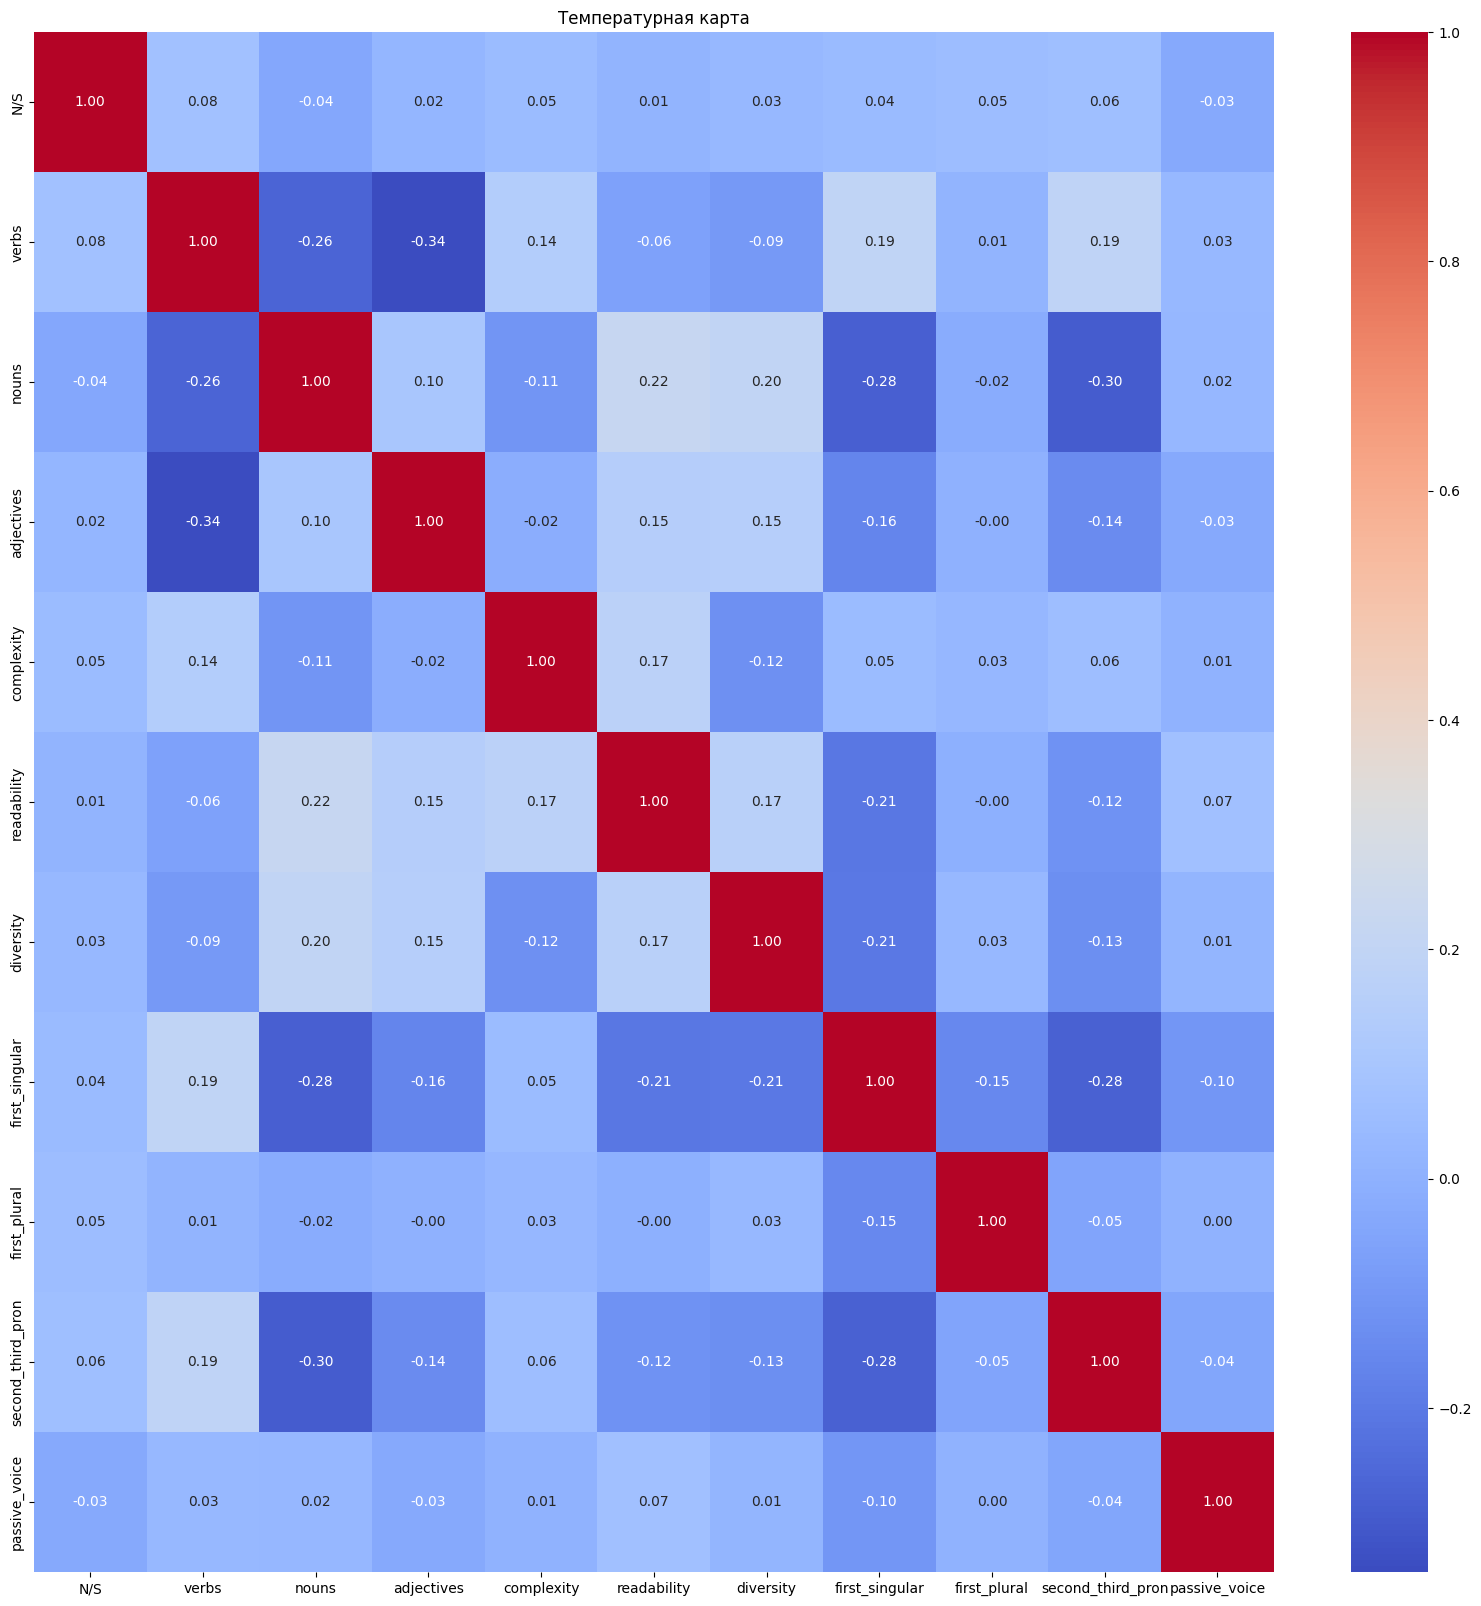

In [ ]:
correlation_matrix = data[['N/S'] + text_columns].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Температурная карта')
plt.show()



По результатам температурной карты есть взаимная корреляция между

Для текстовых признаков корреляция с целевой переменной небольшая,
но подтверждается теория о местоимениях (I увеличиваеся с интроверсией,
а остальные наоборот отриц. коэффициенты)

sadness: grief, remorse, disappointment

anger: annoyance, disgust, disapproval

fear: nervousness, embarrasment, confusion

joy: optimism, excitement, amusement

admiration: desire, love, pride


In [ ]:
data['sadness'] = data['sadness'] + data['grief'] + data['remorse'] + data['disappointment']
data['anger'] = data['anger'] + data['annoyance'] + data['disgust'] + data['disapproval']
data['fear'] = data['fear'] + data['nervousness'] + data['embarrassment'] + data['confusion']
data['joy'] = data['joy'] + data['optimism'] + data['amusement'] + data['excitement']
data['admiration'] = data['admiration'] + data['love'] + data['desire'] + data['pride']

scaler = MinMaxScaler()
data[["sadness","anger","fear","joy","admiration"]] = scaler.fit_transform(data[["sadness","anger","fear","joy","admiration"]])

emotions_to_drop =  ['approval', 'realization', 'neutral','disapproval',
                   'confusion', 'annoyance', 'curiosity', 'surprise',
                   'disappointment', 'excitement', 'embarrassment', 'optimism',
                   'nervousness', 'disgust', 'relief', 'desire', 'love', 'amusement',
                   'caring','pride','remorse', 'grief', 'gratitude']

data.drop(emotions_to_drop, axis=1, inplace=True)

In [ ]:
data.drop(["index","type","posts","encoded_type","post_length","indirect_objects","direct_objects"],axis=1, inplace=True)

In [ ]:
numerical_columns = data.select_dtypes(include=[np.number]).columns
nan_rows = data[numerical_columns].isnull().any(axis=1)
data = data[~nan_rows]
data.reset_index(drop=True, inplace=True)
data.describe()

,I/E,N/S,F/T,J/P,joy,fear,anger,sadness,admiration,verbs,nouns,adjectives,complexity,readability,diversity,first_singular,first_plural,second_third_pron,passive_voice
count,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000,79448.000000
mean,0.518301,0.527930,0.529025,0.492473,0.075706,0.053124,0.107276,0.059910,0.074978,0.125744,0.134627,0.064840,0.068215,0.054662,0.091029,0.052497,0.005237,0.040876,0.005094
std,0.499668,0.499222,0.499160,0.499946,0.151163,0.108779,0.167074,0.132138,0.148522,0.032062,0.041146,0.027416,0.023499,0.031081,0.037434,0.038013,0.012012,0.029605,0.007944
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.004958,0.003722,0.011855,0.003766,0.003245,0.105429,0.107143,0.046296,0.053571,0.035927,0.067262,0.020134,0.000000,0.019417,0.000000
50%,1.000000,1.000000,1.000000,0.000000,0.012623,0.009372,0.031963,0.009934,0.009644,0.125714,0.132530,0.063492,0.067797,0.050347,0.086813,0.048077,0.000000,0.036364,0.000000
75%,1.000000,1.000000,1.000000,1.000000,0.042133,0.040475,0.114892,0.037053,0.049643,0.145833,0.160000,0.081250,0.083067,0.066765,0.109489,0.079646,0.005051,0.057692,0.008621
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.304878,0.514851,0.304348,0.220000,1.000000,1.000000,0.234043,0.170732,0.282609,0.096154


.......


i/E Feature Scores:
           Feature      Score
3          sadness  12.798295
4       admiration  12.377744
0              joy   7.742158
11  first_singular   7.121863
1             fear   3.414601
8       complexity   0.772582
10       diversity   0.686039
5            verbs   0.679748
2            anger   0.649244
6            nouns   0.590469

F/T Feature Scores:
              Feature       Score
4          admiration  173.869387
0                 joy  111.210817
2               anger   91.967582
3             sadness   61.838077
11     first_singular   52.491879
6               nouns   16.313123
1                fear    5.779078
9         readability    5.687847
13  second_third_pron    3.020347
5               verbs    2.720249

N/S Feature Scores:
              Feature      Score
4          admiration  79.862495
2               anger  53.296496
3             sadness  47.001424
0                 joy  15.803244
1                fear   8.734095
13  second_third_pron   5.577243
12       first_plural   4.951955
11     first_singular   3.158887
5               verbs   3.103799
6               nouns   1.439345

J/P Feature Scores:
              Feature      Score
2               anger  34.884222
4          admiration  10.381301
11     first_singular   8.503015
0                 joy   7.264332
3             sadness   3.892601
6               nouns   2.610453
13  second_third_pron   1.048766
1                fear   1.022235
5               verbs   0.957859
8          complexity   0.432344

**TF IDF VECT**

In [ ]:
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_vectorized.csv',lineterminator='\n')
data.drop(["index","type","posts","encoded_type","post_length","indirect_objects","direct_objects"],axis=1, inplace=True)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

vector=CountVectorizer(stop_words='english')
features=vector.fit_transform(data["cleaned_text"])

transform = TfidfTransformer()
vectorized =  transform.fit_transform(features).toarray()
finaldf=pd.DataFrame(vectorized)
#finaldf.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_tfidf.csv', index=False)

In [ ]:
#finaldf = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_tfidf.csv',lineterminator='\n')

In [ ]:
X_data = finaldf
Y_data= data.iloc[:,0:4]

X_train_IE, X_test_IE, Y_train_IE, Y_test_IE = train_test_split(X_data, Y_data['I/E'], test_size=0.2, random_state=42,stratify=Y_data)
X_train_NS, X_test_NS, Y_train_NS, Y_test_NS = train_test_split(X_data, Y_data['N/S'], test_size=0.2, random_state=42,stratify=Y_data)
X_train_FT, X_test_FT, Y_train_FT, Y_test_FT = train_test_split(X_data, Y_data['F/T'], test_size=0.2, random_state=42,stratify=Y_data)
X_train_JP, X_test_JP, Y_train_JP, Y_test_JP = train_test_split(X_data, Y_data['J/P'], test_size=0.2, random_state=42,stratify=Y_data)

In [ ]:
def try_model(model):
  # I/E
  y_pred_IE = model.fit(X_train_IE, Y_train_IE).predict(X_test_IE)
  predictionsIE = [round(value) for value in y_pred_IE]
  accuracyIE = accuracy_score(Y_test_IE, predictionsIE)
  print("Accuracy for I/E: ", accuracyIE)
  print("\nClassification report for I/E:")
  print(classification_report(Y_test_IE, y_pred_IE))

  # N/S
  y_pred_NS = model.fit(X_train_NS, Y_train_NS).predict(X_test_NS)
  predictionsNS = [round(value) for value in y_pred_NS]
  accuracyNS = accuracy_score(Y_test_NS, predictionsNS)
  print("\nAccuracy for N/S: ", accuracyNS)
  print("\nClassification report for N/S:")
  print(classification_report(Y_test_NS, y_pred_NS))

  # F/T
  y_pred_FT = model.fit(X_train_FT, Y_train_FT).predict(X_test_FT)
  predictionsFT = [round(value) for value in y_pred_FT]
  accuracyFT = accuracy_score(Y_test_FT, predictionsFT)
  print("\nAccuracy for F/T: ", accuracyFT)
  print("\nClassification report for F/T:")
  print(classification_report(Y_test_FT, y_pred_FT))

  # J/P
  y_pred_JP = model.fit(X_train_JP, Y_train_JP).predict(X_test_JP)
  predictionsJP = [round(value) for value in y_pred_JP]
  accuracyJP = accuracy_score(Y_test_JP, predictionsJP)
  print("\nAccuracy for J/P: ", accuracyJP)
  print("\nClassification report for J/P:")
  print(classification_report(Y_test_JP, y_pred_JP))

In [ ]:
rf_clf = RandomForestClassifier(random_state=42)
print("Random forest")
try_model(rf_clf)

Random forest
Accuracy for I/E:  0.5919879442421198

Classification report for I/E:
              precision    recall  f1-score   support

         0.0       0.59      0.51      0.55      7671
         1.0       0.59      0.67      0.63      8255

    accuracy                           0.59     15926
   macro avg       0.59      0.59      0.59     15926
weighted avg       0.59      0.59      0.59     15926


Accuracy for N/S:  0.6641969107120432

Classification report for N/S:
              precision    recall  f1-score   support

         0.0       0.66      0.60      0.63      7523
         1.0       0.67      0.72      0.69      8403

    accuracy                           0.66     15926
   macro avg       0.66      0.66      0.66     15926
weighted avg       0.66      0.66      0.66     15926


Accuracy for F/T:  0.6569760140650509

Classification report for F/T:
              precision    recall  f1-score   support

         0.0       0.68      0.51      0.58      7496
         1.

In [ ]:
model_lr = LogisticRegression(class_weight='balanced', solver='saga', max_iter=50000)
print("Logistic Regression")
try_model(model_lr)

Logistic Regression
Accuracy for I/E:  0.5901042320733392

Classification report for I/E:
              precision    recall  f1-score   support

         0.0       0.57      0.58      0.58      7671
         1.0       0.61      0.60      0.60      8255

    accuracy                           0.59     15926
   macro avg       0.59      0.59      0.59     15926
weighted avg       0.59      0.59      0.59     15926


Accuracy for N/S:  0.6748712796684666

Classification report for N/S:
              precision    recall  f1-score   support

         0.0       0.65      0.69      0.67      7523
         1.0       0.70      0.67      0.68      8403

    accuracy                           0.67     15926
   macro avg       0.67      0.68      0.67     15926
weighted avg       0.68      0.67      0.68     15926


Accuracy for F/T:  0.6613085520532462

Classification report for F/T:
              precision    recall  f1-score   support

         0.0       0.64      0.64      0.64      7496
     

In [ ]:
params = {}
params['n_estimators'] = 300
params['learning_rate'] = 0.3

xgb_model = XGBClassifier(**params)
print("XGB Classifier")
try_model(xgb_model)

XGB Classifier
Accuracy for I/E:  0.592741429109632

Classification report for I/E:
              precision    recall  f1-score   support

         0.0       0.58      0.57      0.57      7671
         1.0       0.61      0.62      0.61      8255

    accuracy                           0.59     15926
   macro avg       0.59      0.59      0.59     15926
weighted avg       0.59      0.59      0.59     15926


Accuracy for N/S:  0.6690945623508728

Classification report for N/S:
              precision    recall  f1-score   support

         0.0       0.65      0.66      0.65      7523
         1.0       0.69      0.68      0.68      8403

    accuracy                           0.67     15926
   macro avg       0.67      0.67      0.67     15926
weighted avg       0.67      0.67      0.67     15926


Accuracy for F/T:  0.6555946251412784

Classification report for F/T:
              precision    recall  f1-score   support

         0.0       0.65      0.58      0.61      7496
         1.

**Обучение моделей**

In [ ]:
%pip install transformers
%pip install datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 7.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 7.0 MB/s eta 0:00:00


In [ ]:
%pip install accelerate -U
from transformers import Trainer, TrainingArguments
import accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.6/302.6 kB 3.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
#from tensorflow import keras
#import tensorflow as tf
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_vectorized.csv',lineterminator='\n')
data['I/E'] = data['I/E'].astype(int)

data['sadness'] = data['sadness'] + data['grief'] + data['remorse'] + data['disappointment']
data['anger'] = data['anger'] + data['annoyance'] + data['disgust'] + data['disapproval']
data['fear'] = data['fear'] + data['nervousness'] + data['embarrassment'] + data['confusion']
data['joy'] = data['joy'] + data['optimism'] + data['amusement'] + data['excitement']
data['admiration'] = data['admiration'] + data['love'] + data['desire'] + data['pride']

scaler = MinMaxScaler()
data[["sadness","anger","fear","joy","admiration"]] = scaler.fit_transform(data[["sadness","anger","fear","joy","admiration"]])

emotions_to_drop =  ['approval', 'realization', 'neutral','disapproval',
                   'confusion', 'annoyance', 'curiosity', 'surprise',
                   'disappointment', 'excitement', 'embarrassment', 'optimism',
                   'nervousness', 'disgust', 'relief', 'desire', 'love', 'amusement',
                   'caring','pride','remorse', 'grief', 'gratitude']

data.drop(emotions_to_drop, axis=1, inplace=True)

numerical_columns = data.select_dtypes(include=[np.number]).columns
nan_rows = data[numerical_columns].isnull().any(axis=1)
data = data[~nan_rows]
data.reset_index(drop=True, inplace=True)

data['vector'] = data['vector'].apply(lambda x: list(map(float, x.strip('[]').split())))
data['vector'] = data['vector'].apply(lambda x: np.array(x, dtype=object))
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: x.split())

In [ ]:
%pip install gensim
from gensim import corpora, models

In [ ]:
dictionary = corpora.Dictionary(data['cleaned_text'])
corpus = [dictionary.doc2bow(text) for text in data['cleaned_text']]

lda_model = models.LdaModel(corpus, num_topics=10, id2word=dictionary, passes=25)

# Функция для получения темы для документа
def get_document_topics(text):
    bow = dictionary.doc2bow(text)
    topics = lda_model.get_document_topics(bow)
    # Возвращаем в виде словаря, где ключ - номер темы, значение - вероятность
    return {f'topic_{topic[0]}': topic[1] for topic in topics}

data['topics'] = data['cleaned_text'].apply(get_document_topics)
topics_df = pd.DataFrame(data['topics'].tolist())
data = pd.concat([data, topics_df], axis=1).drop(columns=['topics'])

data = data.fillna(0)
data.to_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_topics.csv', index=False)

In [ ]:
data.columns

Index(['index', 'type', 'posts', 'encoded_type', 'I/E', 'N/S', 'F/T', 'J/P',
       'post_length', 'cleaned_text', 'joy', 'fear', 'anger', 'sadness',
       'admiration', 'verbs', 'nouns', 'adjectives', 'complexity',
       'readability', 'diversity', 'first_singular', 'first_plural',
       'second_third_pron', 'direct_objects', 'indirect_objects',
       'passive_voice', 'vector', 'topic_0', 'topic_5', 'topic_6', 'topic_7',
       'topic_9', 'topic_1', 'topic_3', 'topic_8', 'topic_4', 'topic_2'],
      dtype='object')

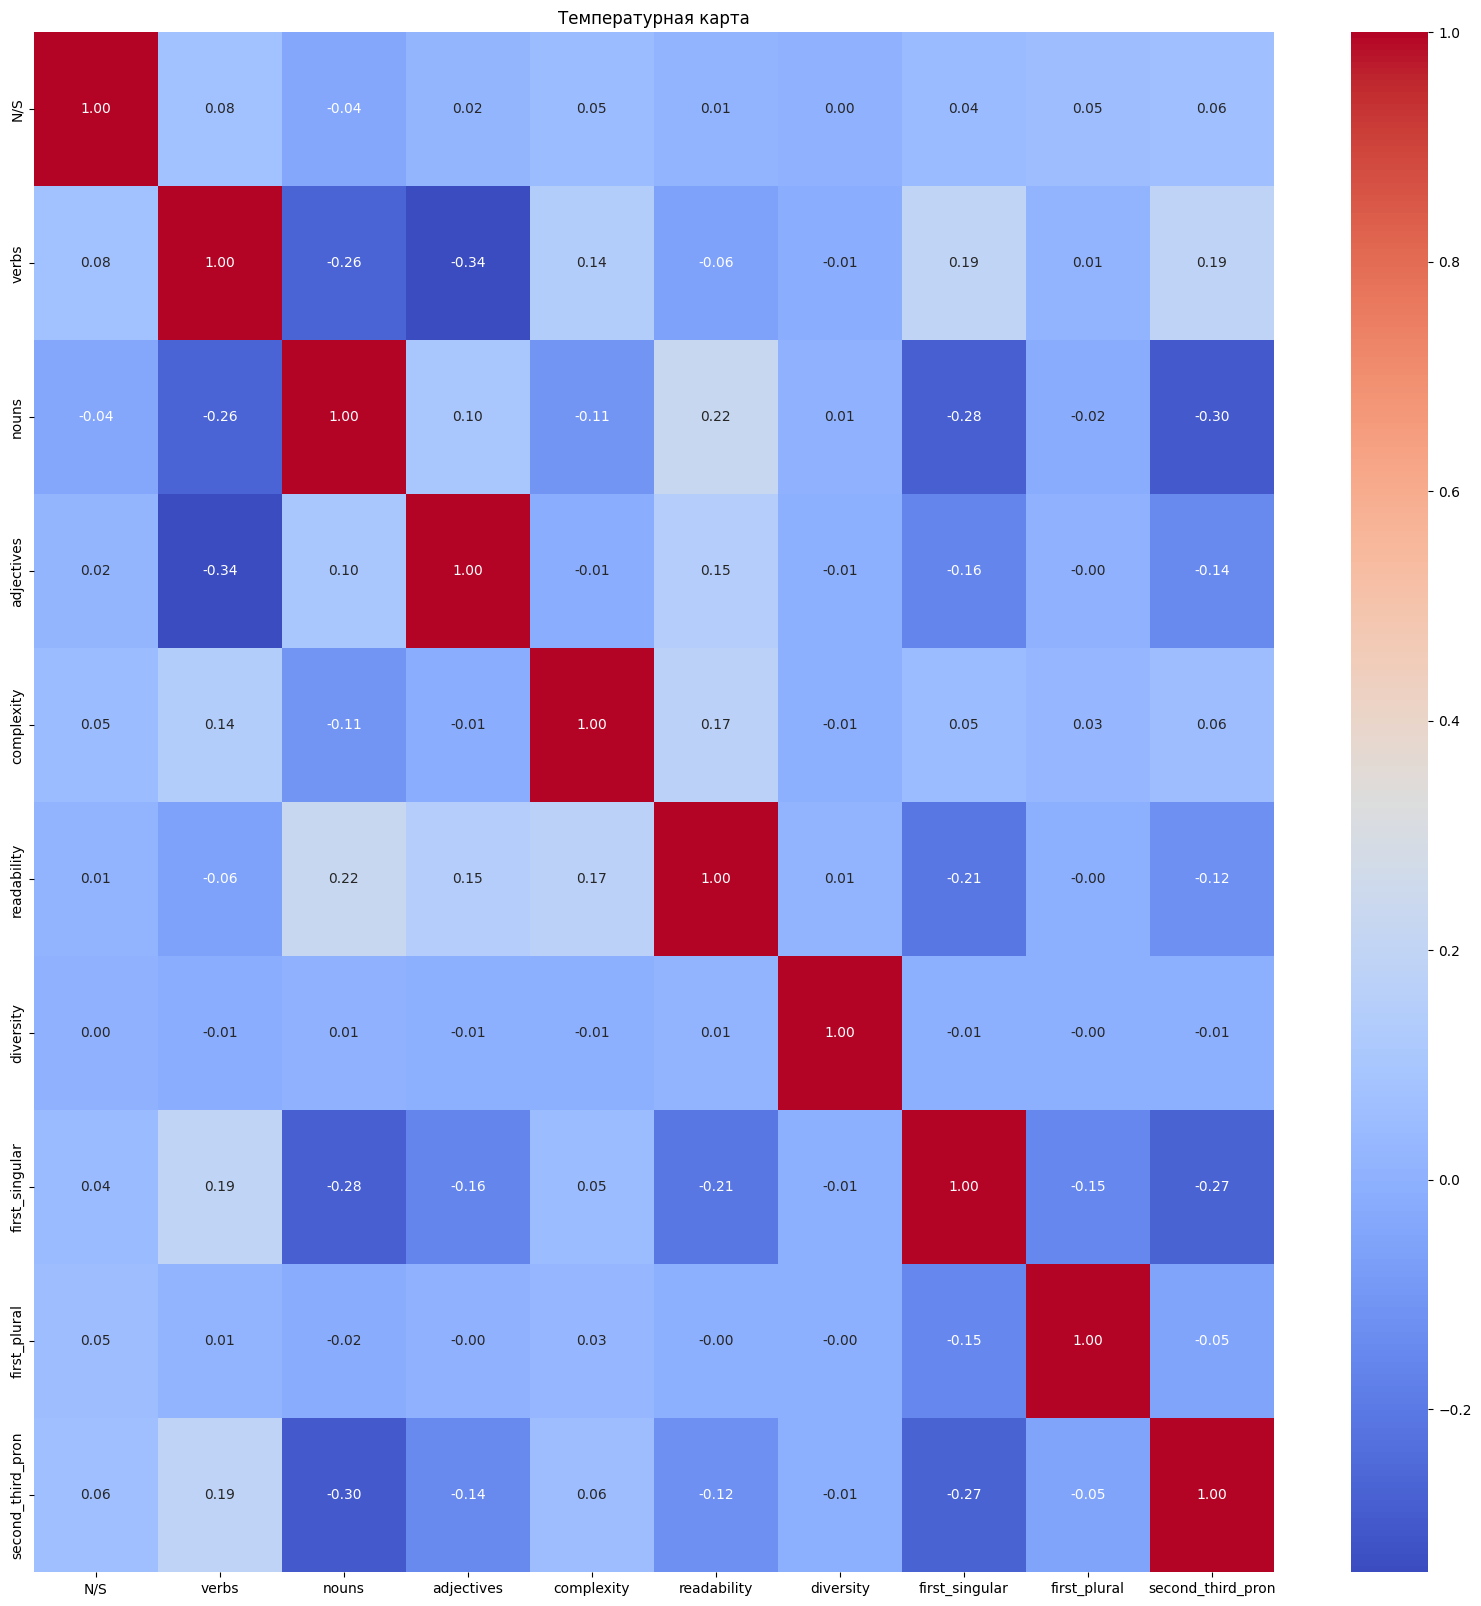

In [ ]:
topic_columns = [col for col in data.columns if col.startswith('topic_')]
emotion_columns = ['verbs', 'nouns', 'adjectives', 'complexity',
       'readability', 'diversity', 'first_singular', 'first_plural',
       'second_third_pron']
correlation_matrix = data[['N/S'] + emotion_columns].corr()

plt.figure(figsize=(20, 20))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Температурная карта')
plt.show()
# ну как будто бы вообще не помогло но буду хранить надежду...

In [ ]:
data = pd.read_csv('/content/drive/MyDrive/Диплом/Colab notebooks/Preprocessed/final_topics.csv',lineterminator='\n')

data['vector'] = data['vector'].apply(lambda x: list(map(float, x.strip('[]').split())))
data['vector'] = data['vector'].apply(lambda x: np.array(x, dtype=object))
vector_2d = np.array([vec for vec in data['vector']])
topic_columns = [col for col in data.columns if col.startswith('topic_')]
topic_features = data[topic_columns].values
ling_features = data[['verbs', 'nouns', 'adjectives', 'readability', 'first_singular', 'second_third_pron']].values
emotion_features = data[['joy', 'fear', 'anger', 'sadness','admiration']].values

X = np.hstack((vector_2d, topic_features, ling_features, emotion_features))

X_trainIE, X_testIE, y_trainIE, y_testIE = train_test_split(X, data['I/E'], test_size=0.2, random_state=100)
X_trainNS, X_testNS, y_trainNS, y_testNS = train_test_split(X, data['N/S'], test_size=0.2, random_state=100)
X_trainFT, X_testFT, y_trainFT, y_testFT = train_test_split(X, data['F/T'], test_size=0.2, random_state=100)
X_trainJP, X_testJP, y_trainJP, y_testJP = train_test_split(X, data['J/P'], test_size=0.2, random_state=100)

Остальные модели со склеарн

In [ ]:
def tryModel(X_train, y_train, X_test, y_test, model, modelname):

    print(modelname)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    accuracy = accuracy_score(y_test, y_pred)
    print("\nAccuracy:", accuracy)
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {modelname}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    # ROC AUC Curve
    if len(np.unique(y_test)) == 2:
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
        roc_auc = roc_auc_score(y_test, y_pred_proba)

        plt.figure(figsize=(10, 7))
        plt.plot(fpr, tpr, color='blue', label=f'ROC Curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'ROC AUC Curve - {modelname}')
        plt.legend(loc="lower right")
        plt.show()

    print("\n")



I/E Model
XGB

Accuracy: 0.5939344468165264

Classification Report:
              precision    recall  f1-score   support

           0       0.58      0.52      0.55      7620
           1       0.60      0.66      0.63      8306

    accuracy                           0.59     15926
   macro avg       0.59      0.59      0.59     15926
weighted avg       0.59      0.59      0.59     15926



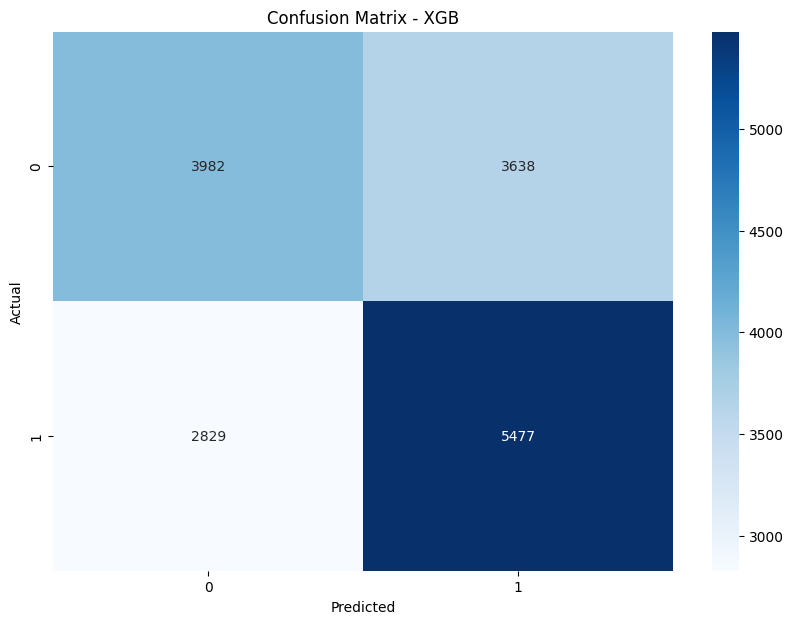

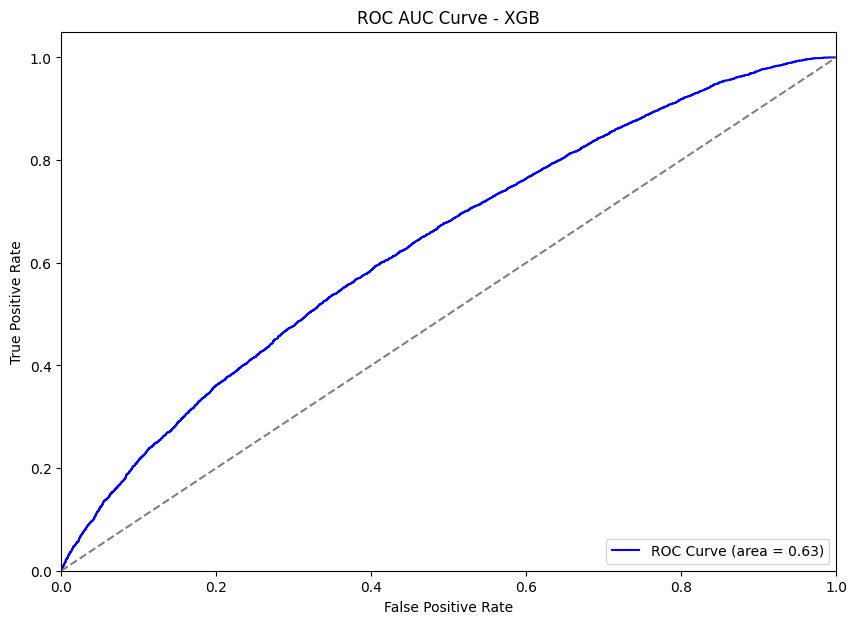



Naive Bayes

Accuracy: 0.5518020846414667

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.43      0.48      7620
           1       0.56      0.66      0.61      8306

    accuracy                           0.55     15926
   macro avg       0.55      0.55      0.54     15926
weighted avg       0.55      0.55      0.55     15926



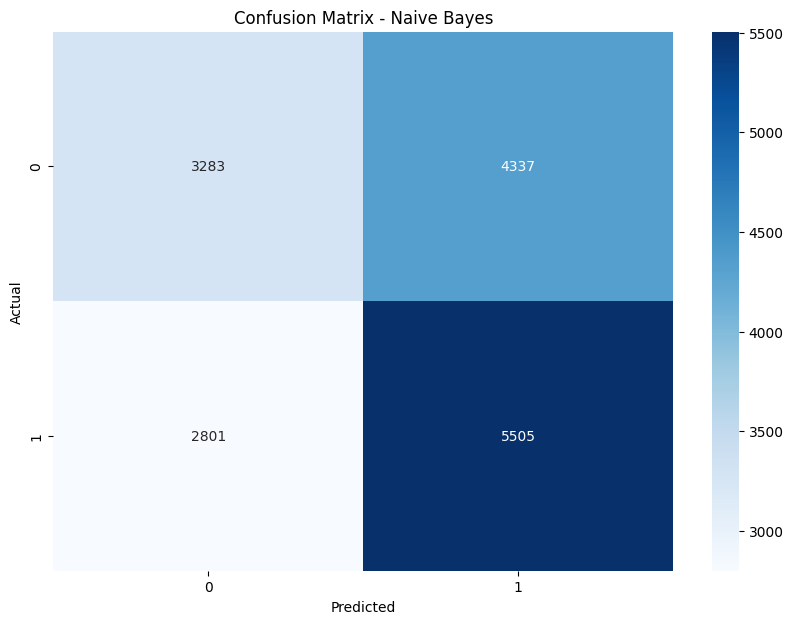

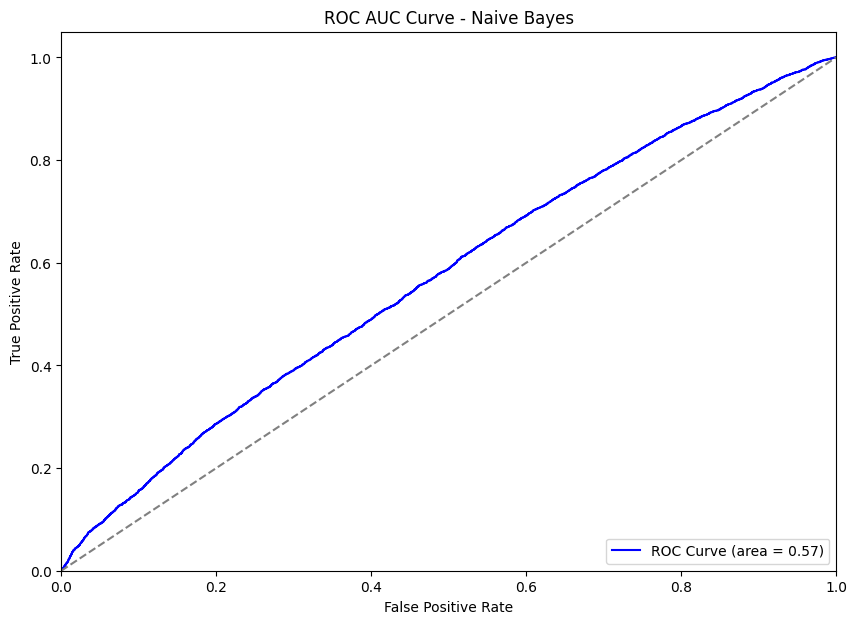



Random forest

Accuracy: 0.5756624387793545

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.54      0.55      7620
           1       0.59      0.61      0.60      8306

    accuracy                           0.58     15926
   macro avg       0.57      0.57      0.57     15926
weighted avg       0.58      0.58      0.58     15926



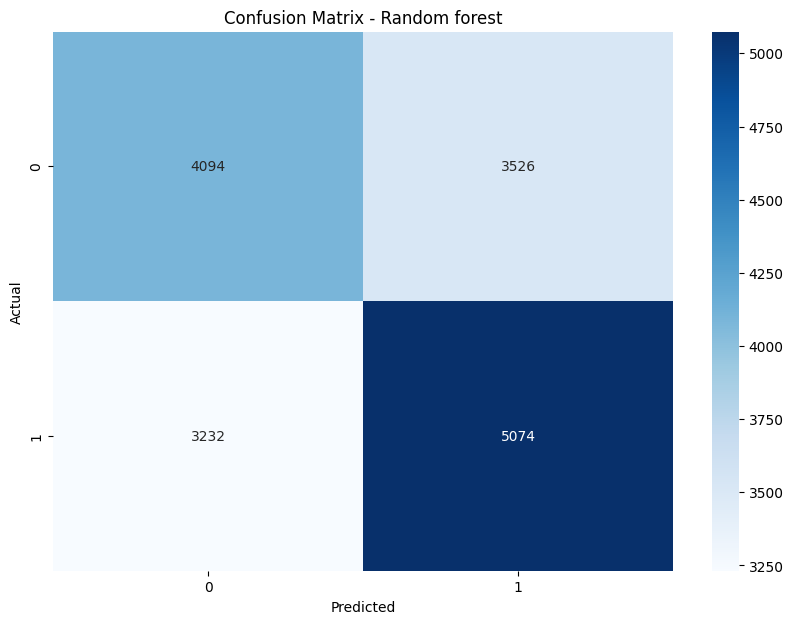

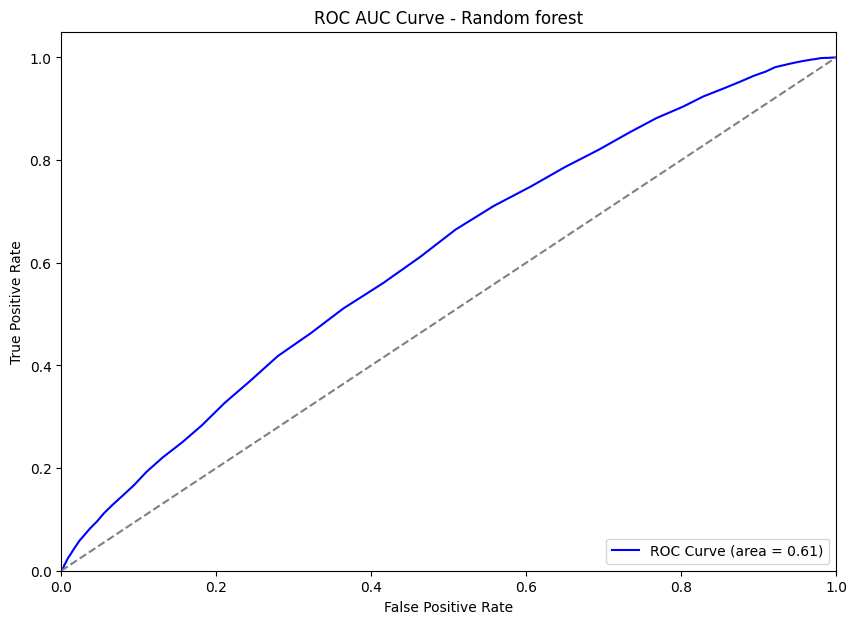



Logistic regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy: 0.5804345096069321

Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.47      0.52      7620
           1       0.58      0.68      0.63      8306

    accuracy                           0.58     15926
   macro avg       0.58      0.58      0.57     15926
weighted avg       0.58      0.58      0.58     15926



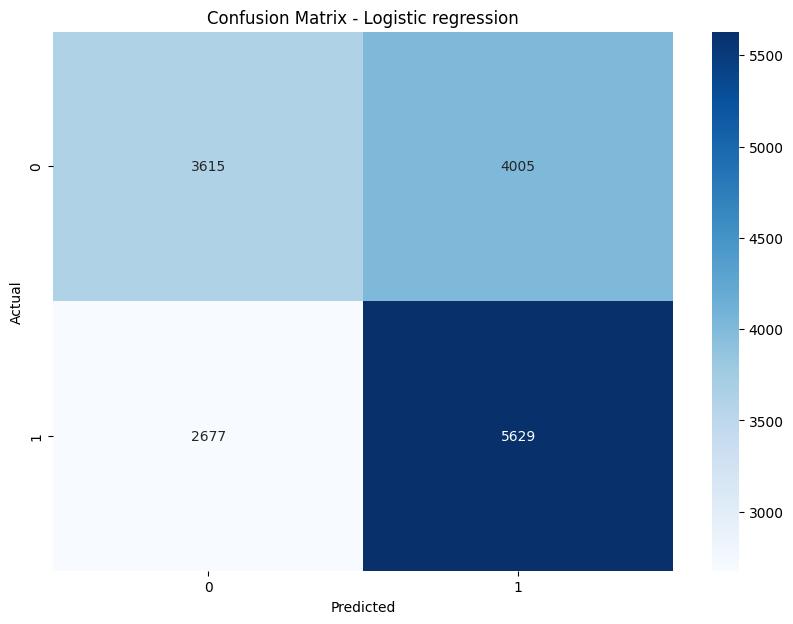

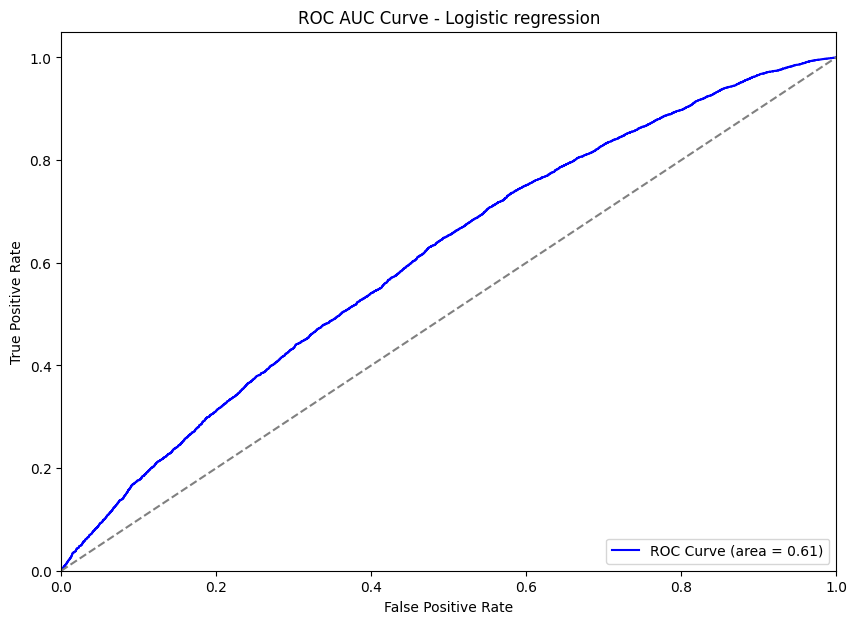



KNN

Accuracy: 0.5354765791787015

Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.56      0.54      7620
           1       0.56      0.51      0.53      8306

    accuracy                           0.54     15926
   macro avg       0.54      0.54      0.54     15926
weighted avg       0.54      0.54      0.54     15926



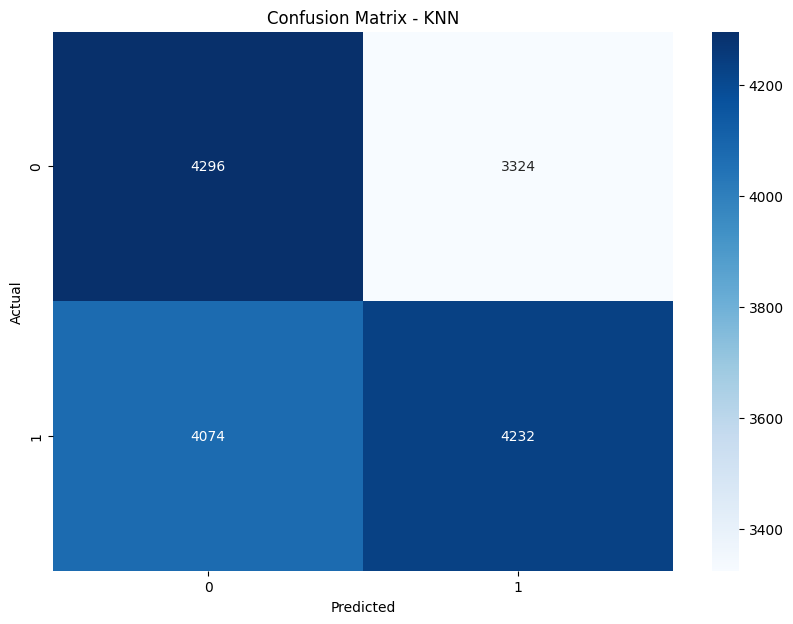

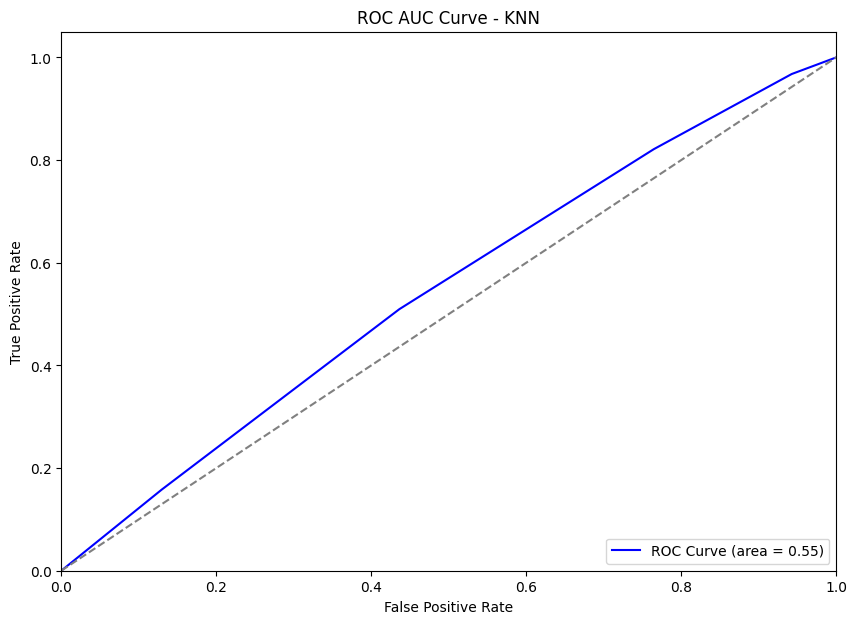

In [ ]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

params = {}
params['objective'] = 'binary:logistic'
params['n_estimators'] = 600
params['learning_rate'] = 0.02
params['max_depth'] = 7

xgb_clf = XGBClassifier(**params)
gnb_clf = GaussianNB()
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=4)
print("I/E Model")
tryModel(X_trainIE, y_trainIE, X_testIE, y_testIE, xgb_clf, "XGB")
tryModel(X_trainIE, y_trainIE, X_testIE, y_testIE, gnb_clf, "Naive Bayes")
tryModel(X_trainIE, y_trainIE, X_testIE, y_testIE, rf_clf, "Random forest")
tryModel(X_trainIE, y_trainIE, X_testIE, y_testIE, lr_clf, "Logistic regression")
tryModel(X_trainIE, y_trainIE, X_testIE, y_testIE, knn_clf, "KNN")

Feature importance

I/E Model
XGB

Accuracy: 0.6013437146803968

Classification Report:
              precision    recall  f1-score   support

           0       0.59      0.53      0.56      7626
           1       0.61      0.67      0.64      8300

    accuracy                           0.60     15926
   macro avg       0.60      0.60      0.60     15926
weighted avg       0.60      0.60      0.60     15926



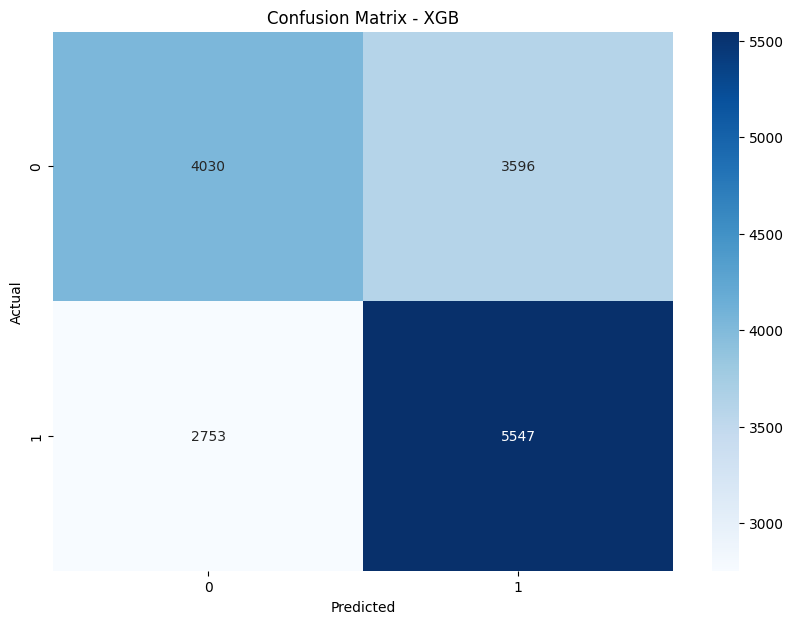

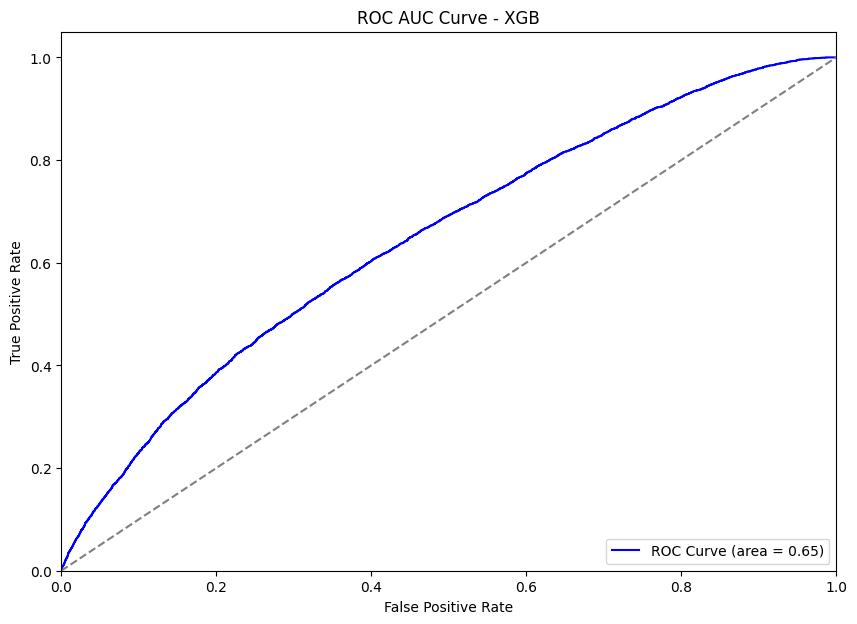

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['n_estimators'] = 600
params['learning_rate'] = 0.02
params['max_depth'] = 7

xgb_clf = XGBClassifier(**params)
print("I/E Model")
tryModel(X_trainIE, y_trainIE, X_testIE, y_testIE, xgb_clf, "XGB")

In [ ]:
import pickle

modelIE = xgb_clf
filename="/content/drive/MyDrive/Диплом/Colab notebooks/trained_IE.sav"
pickle.dump(modelIE, open(filename,"wb"))

Модели для N/S

N/S Model
XGB

Accuracy: 0.6701619992465151

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64      7590
         1.0       0.67      0.72      0.70      8336

    accuracy                           0.67     15926
   macro avg       0.67      0.67      0.67     15926
weighted avg       0.67      0.67      0.67     15926



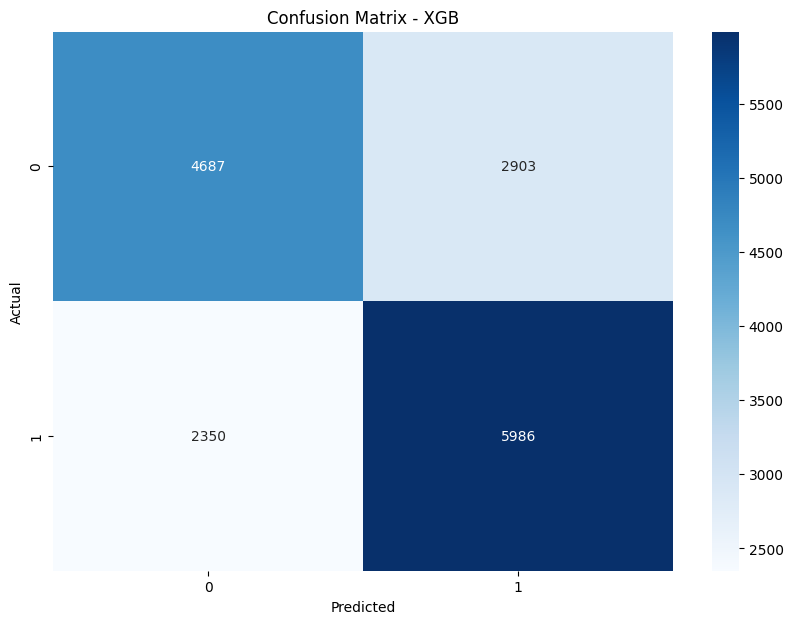

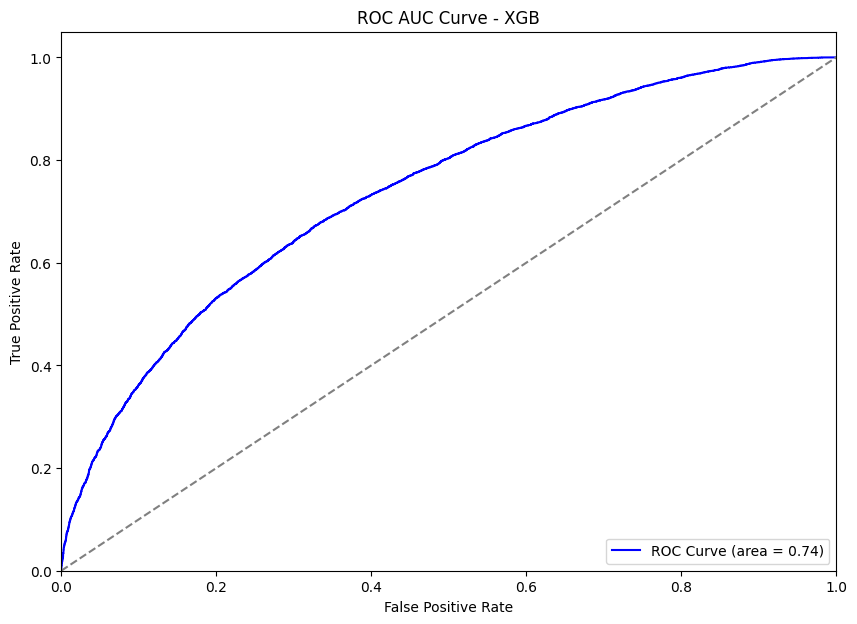



Naive Bayes

Accuracy: 0.623759889488886

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.53      0.57      7590
         1.0       0.62      0.71      0.66      8336

    accuracy                           0.62     15926
   macro avg       0.62      0.62      0.62     15926
weighted avg       0.62      0.62      0.62     15926



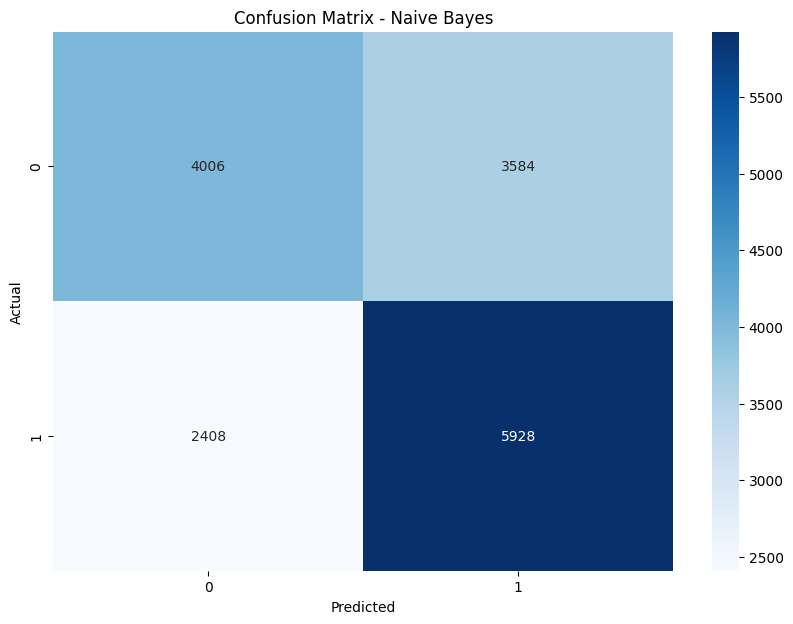

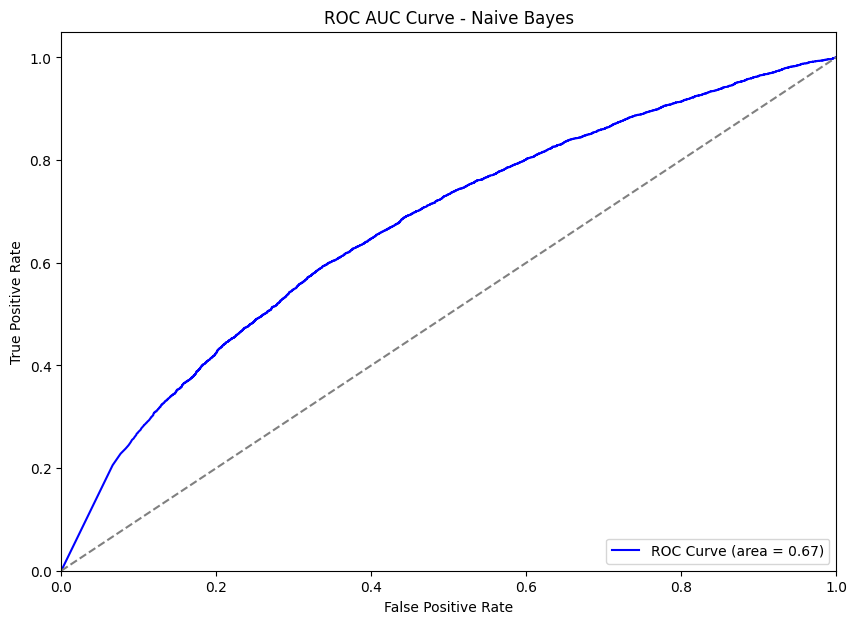



Random forest

Accuracy: 0.6446690945623509

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.65      0.63      7590
         1.0       0.67      0.64      0.65      8336

    accuracy                           0.64     15926
   macro avg       0.64      0.64      0.64     15926
weighted avg       0.65      0.64      0.64     15926



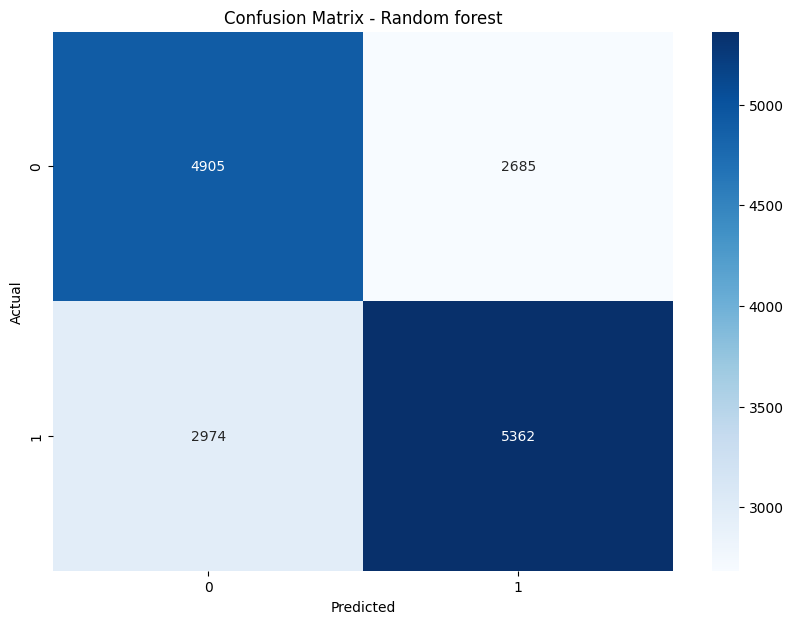

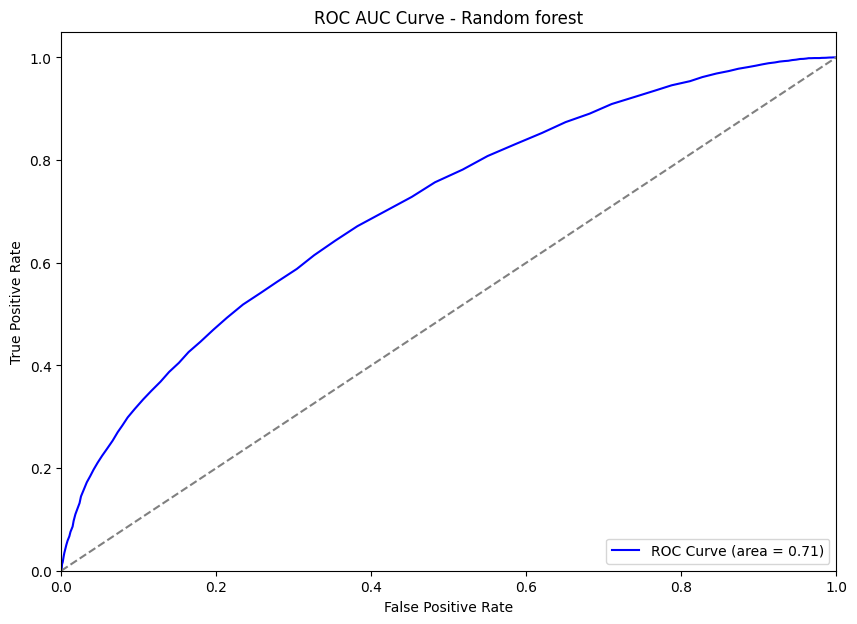



Logistic regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy: 0.6433504960442045

Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.55      0.60      7590
         1.0       0.64      0.73      0.68      8336

    accuracy                           0.64     15926
   macro avg       0.64      0.64      0.64     15926
weighted avg       0.64      0.64      0.64     15926



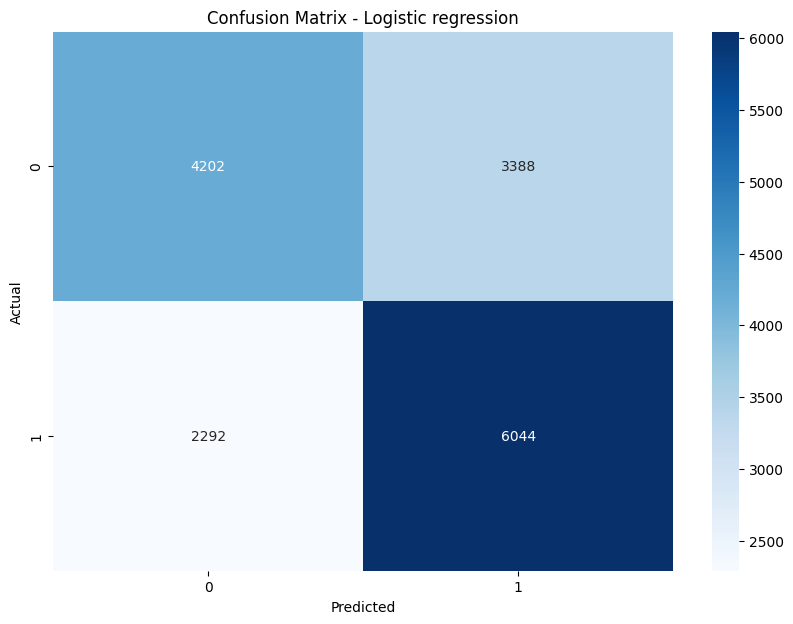

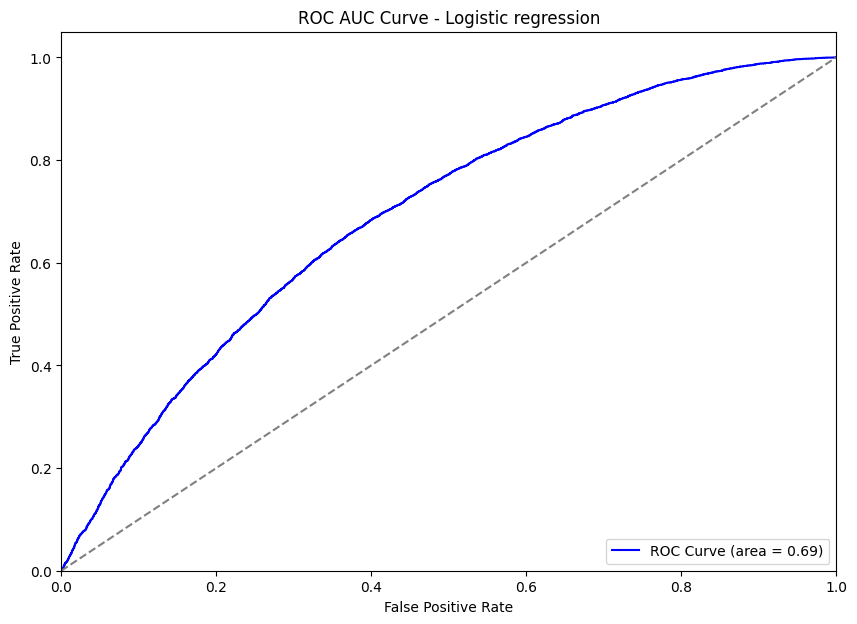



KNN

Accuracy: 0.5923018962702499

Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.46      0.52      7590
         1.0       0.59      0.71      0.65      8336

    accuracy                           0.59     15926
   macro avg       0.59      0.59      0.58     15926
weighted avg       0.59      0.59      0.59     15926



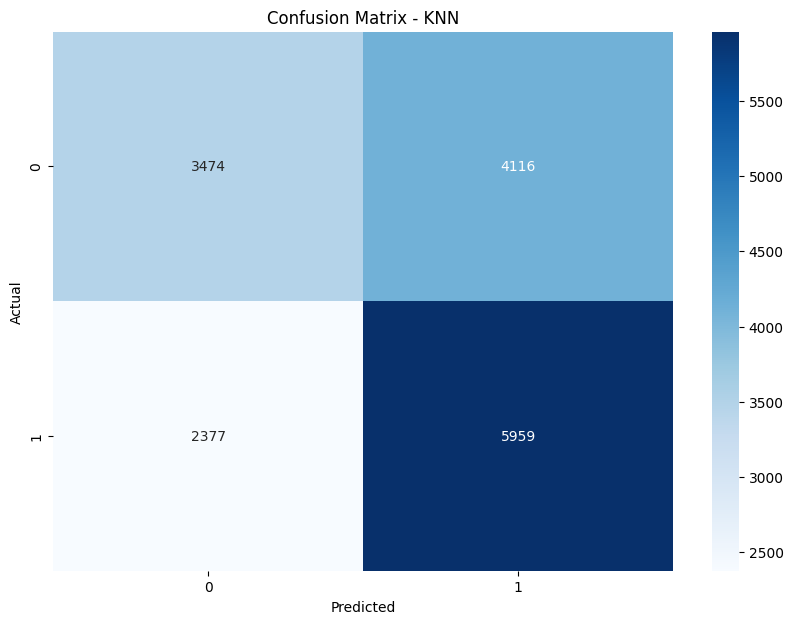

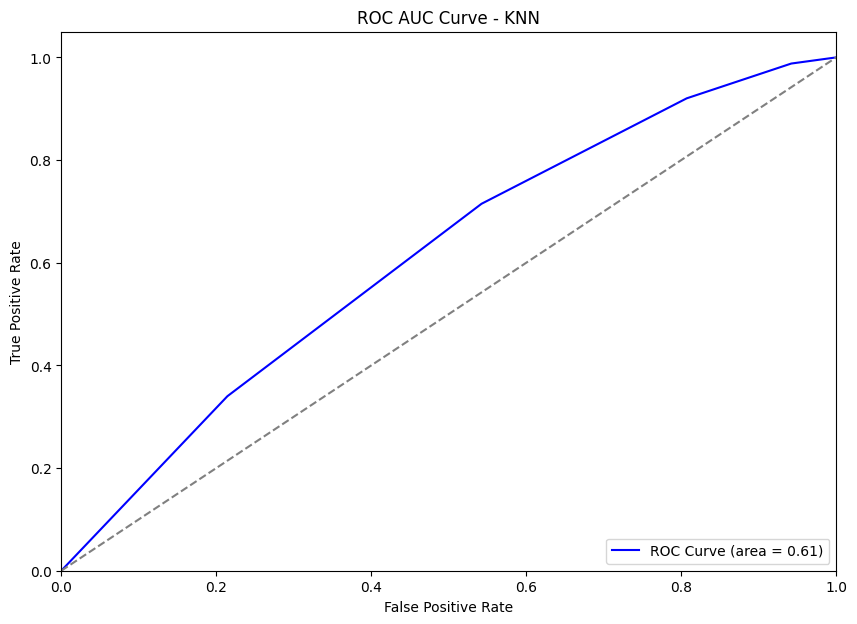

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['n_estimators'] = 600
params['learning_rate'] = 0.02
params['max_depth'] = 7

xgb_clf = XGBClassifier(**params)
gnb_clf = GaussianNB()
rf_clf = RandomForestClassifier(random_state=42)
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=4)
print("N/S Model")
tryModel(X_trainNS, y_trainNS, X_testNS, y_testNS, xgb_clf, "XGB")
tryModel(X_trainNS, y_trainNS, X_testNS, y_testNS, gnb_clf, "Naive Bayes")
tryModel(X_trainNS, y_trainNS, X_testNS, y_testNS, rf_clf, "Random forest")
tryModel(X_trainNS, y_trainNS, X_testNS, y_testNS, lr_clf, "Logistic regression")
tryModel(X_trainNS, y_trainNS, X_testNS, y_testNS, knn_clf, "KNN")

XGB

Accuracy: 0.663317845033279

Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.61      0.63      7590
         1.0       0.67      0.71      0.69      8336

    accuracy                           0.66     15926
   macro avg       0.66      0.66      0.66     15926
weighted avg       0.66      0.66      0.66     15926



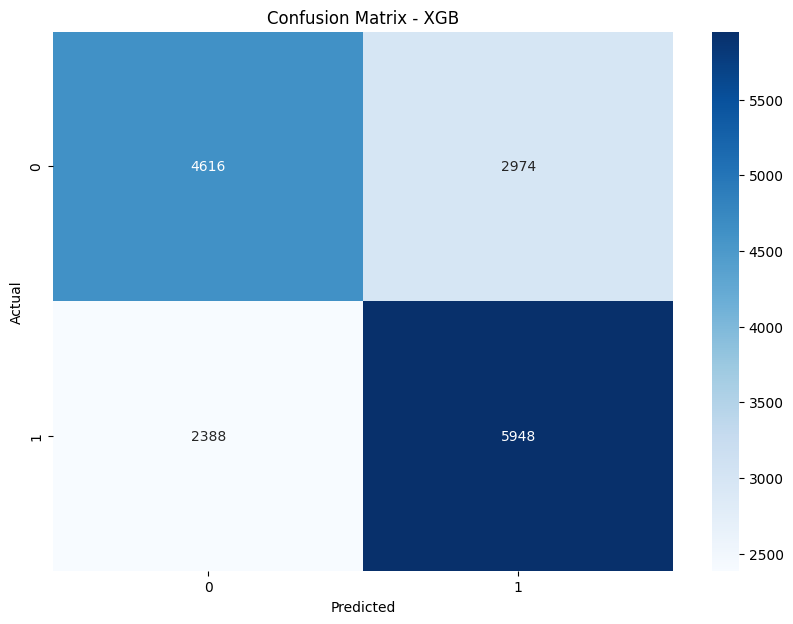

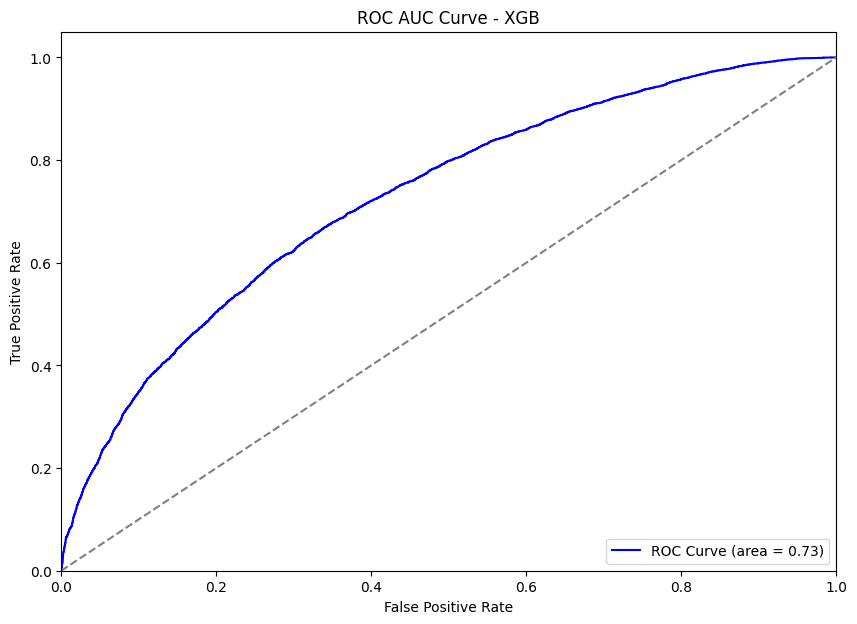

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['n_estimators'] = 600
params['learning_rate'] = 0.02
params['max_depth'] = 7

xgb_clf = XGBClassifier(**params)
tryModel(X_trainNS, y_trainNS, X_testNS, y_testNS, xgb_clf, "XGB")

In [ ]:
#from sklearn.model_selection import GridSearchCV

#param_grid = {
#    'n_estimators': [100, 200, 300, 400],
#    'learning_rate': [0.01, 0.1, 0.2],
#    'max_depth': [3, 5, 7],}

#gb_model = GradientBoostingClassifier()
#grid_search = GridSearchCV(estimator=gb_model, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
#grid_search.fit(X_trainIE, y_trainIE)

#best_params = grid_search.best_params_
#best_model = grid_search.best_estimator_
#y_pred_best = best_model.predict(X_testIE)
#accuracy_best = accuracy_score(y_testIE, y_pred_best)

#print("Best Parameters:", best_params)
#print(f"Best Model Accuracy: {accuracy_best}")

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


N/S Model
XGB

Accuracy: 0.6724224538490519

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.62      0.64      7568
         1.0       0.68      0.72      0.70      8358

    accuracy                           0.67     15926
   macro avg       0.67      0.67      0.67     15926
weighted avg       0.67      0.67      0.67     15926



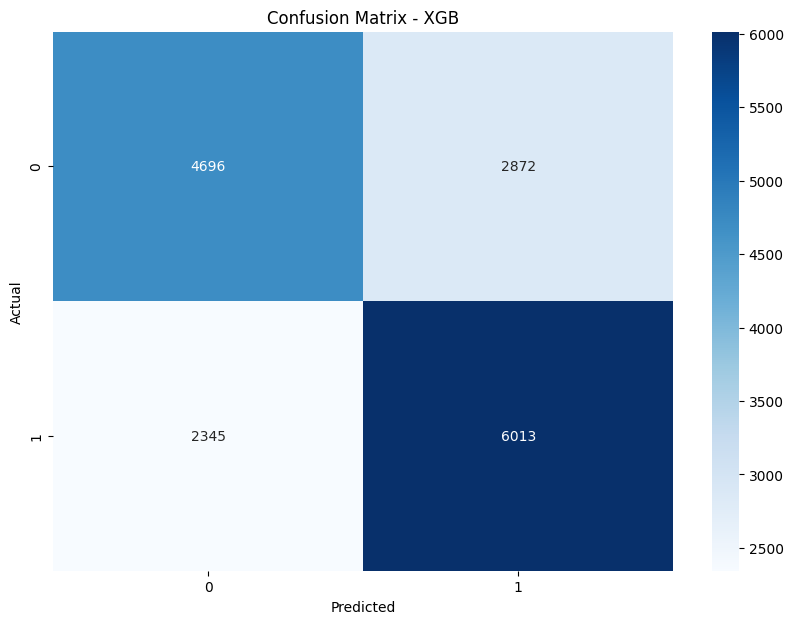

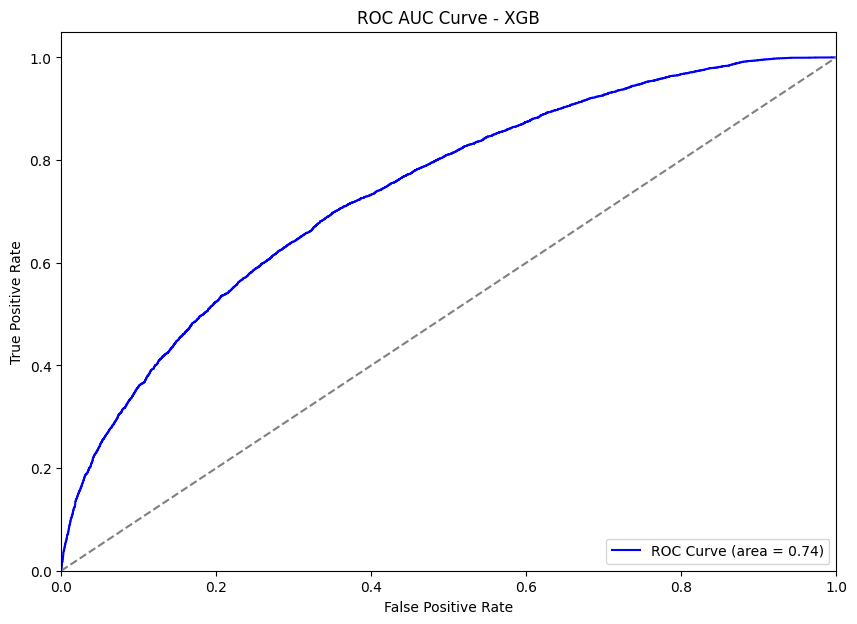

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['n_estimators'] = 600
params['learning_rate'] = 0.02
params['max_depth'] = 7

xgb_clf = XGBClassifier(**params)
print("N/S Model")
tryModel(X_trainNS, y_trainNS, X_testNS, y_testNS, xgb_clf, "XGB")

In [ ]:
modelNS = xgb_clf
filename="/content/drive/MyDrive/Диплом/Colab notebooks/trained_NS.sav"
pickle.dump(modelNS, open(filename,"wb"))

Модель F/T

F/T Model
XGB

Accuracy: 0.6524551048599774

Classification Report:
              precision    recall  f1-score   support

         0.0       0.66      0.53      0.59      7467
         1.0       0.65      0.76      0.70      8459

    accuracy                           0.65     15926
   macro avg       0.65      0.65      0.64     15926
weighted avg       0.65      0.65      0.65     15926



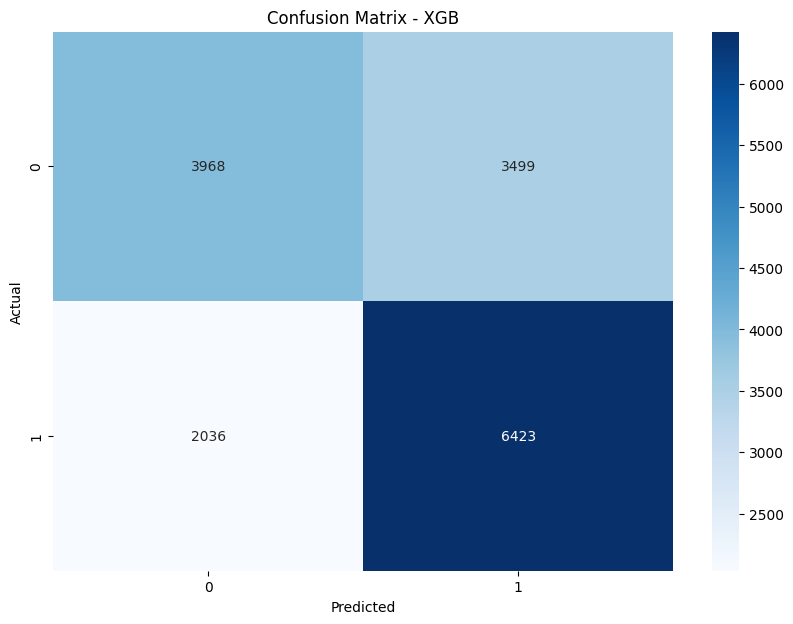

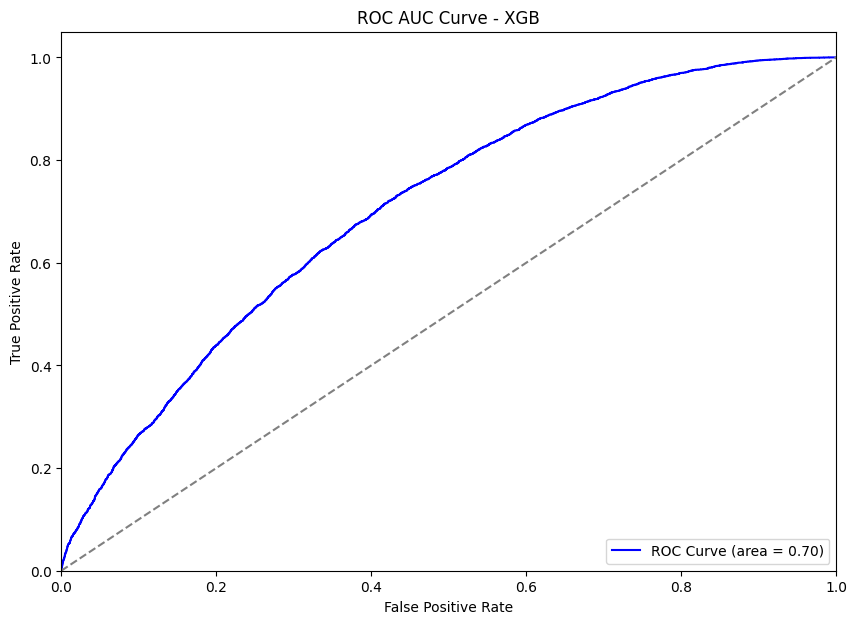



Naive Bayes

Accuracy: 0.6091925153836494

Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.54      0.56      7467
         1.0       0.62      0.67      0.65      8459

    accuracy                           0.61     15926
   macro avg       0.61      0.60      0.60     15926
weighted avg       0.61      0.61      0.61     15926



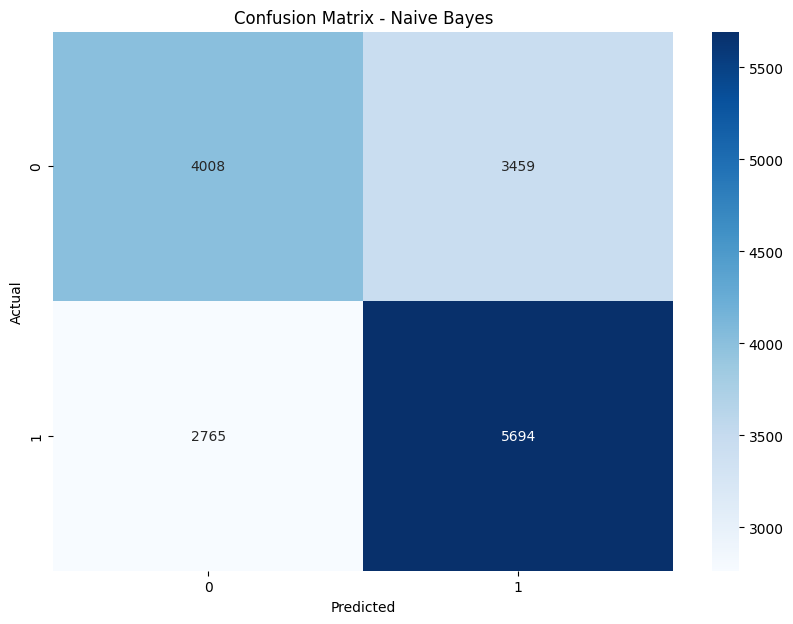

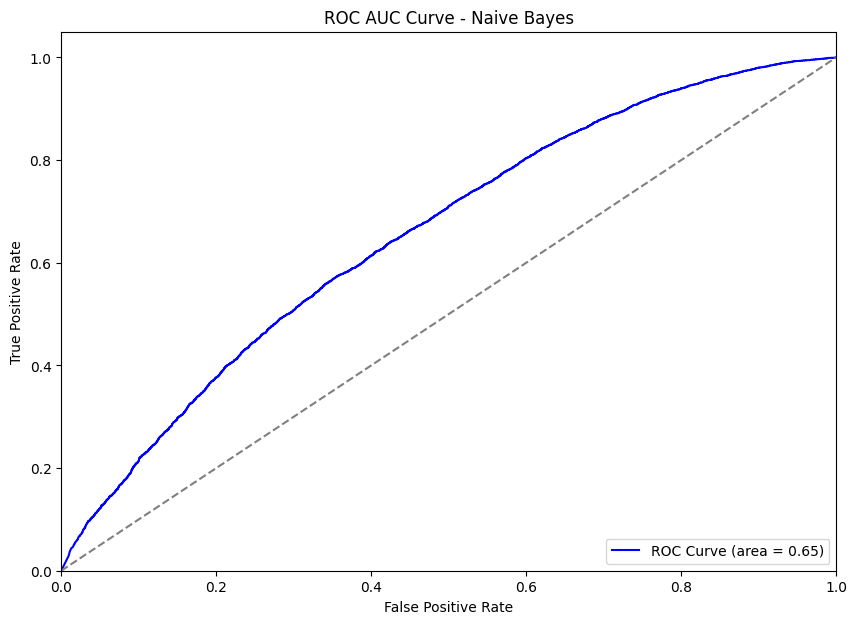



Random forest

Accuracy: 0.6314831093808866

Classification Report:
              precision    recall  f1-score   support

         0.0       0.63      0.52      0.57      7467
         1.0       0.63      0.73      0.68      8459

    accuracy                           0.63     15926
   macro avg       0.63      0.63      0.62     15926
weighted avg       0.63      0.63      0.63     15926



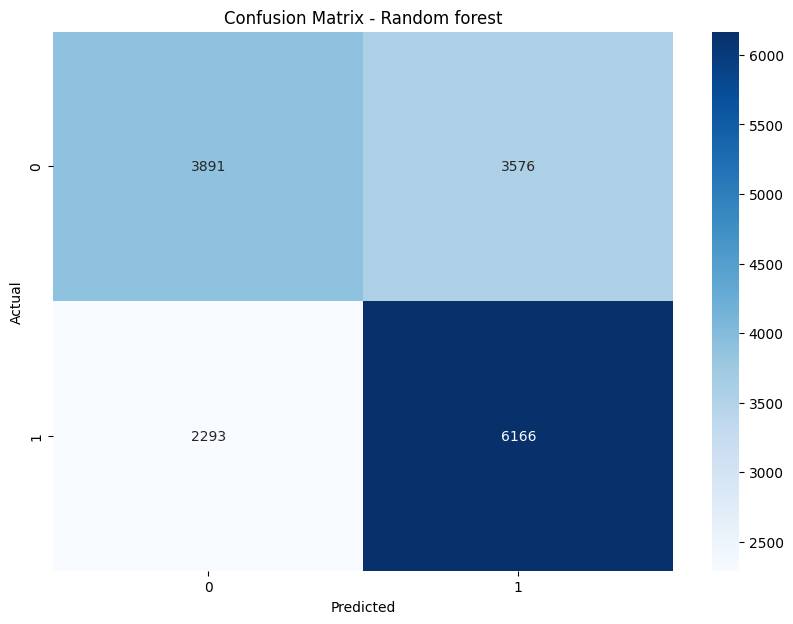

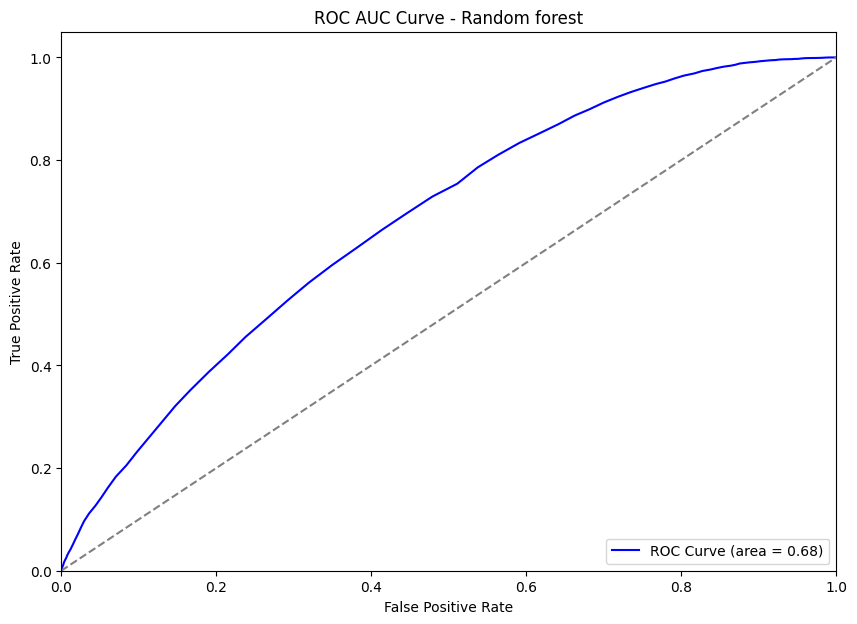



Logistic regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy: 0.6525178952656034

Classification Report:
              precision    recall  f1-score   support

         0.0       0.65      0.55      0.60      7467
         1.0       0.65      0.74      0.69      8459

    accuracy                           0.65     15926
   macro avg       0.65      0.65      0.65     15926
weighted avg       0.65      0.65      0.65     15926



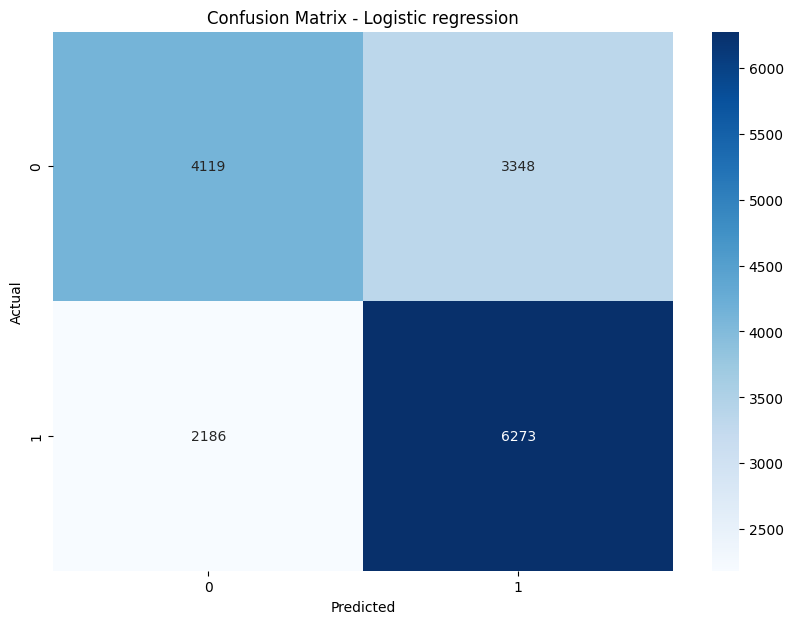

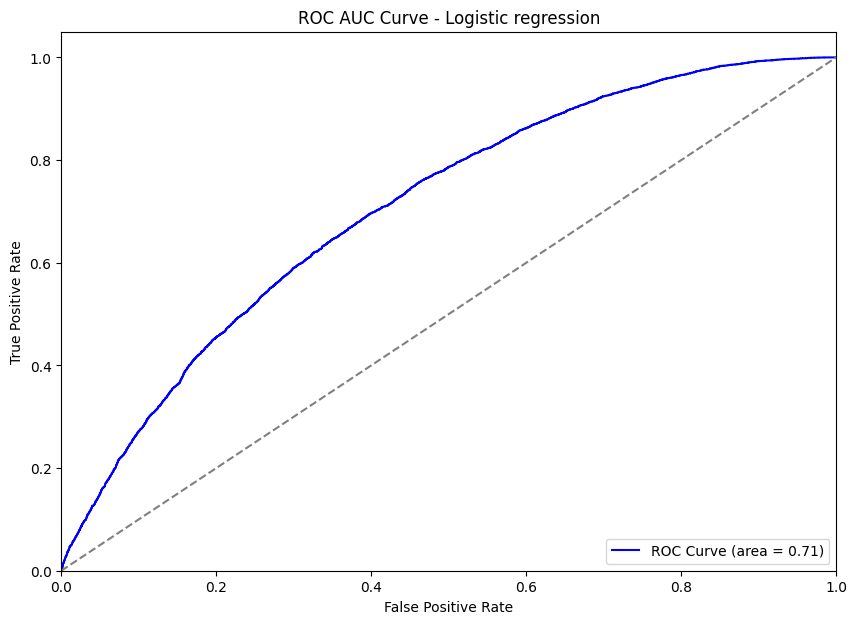



KNN

Accuracy: 0.571078739168655

Classification Report:
              precision    recall  f1-score   support

         0.0       0.53      0.71      0.61      7467
         1.0       0.64      0.45      0.53      8459

    accuracy                           0.57     15926
   macro avg       0.58      0.58      0.57     15926
weighted avg       0.59      0.57      0.56     15926



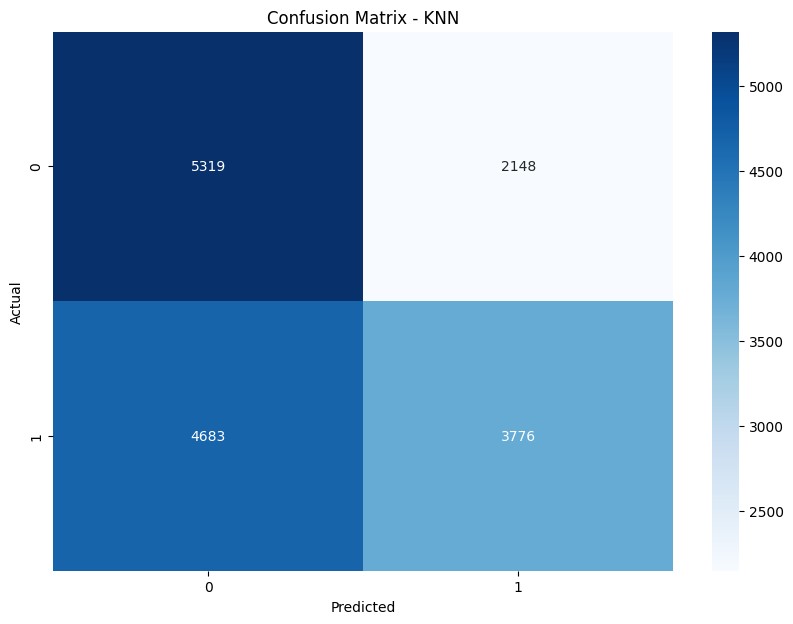

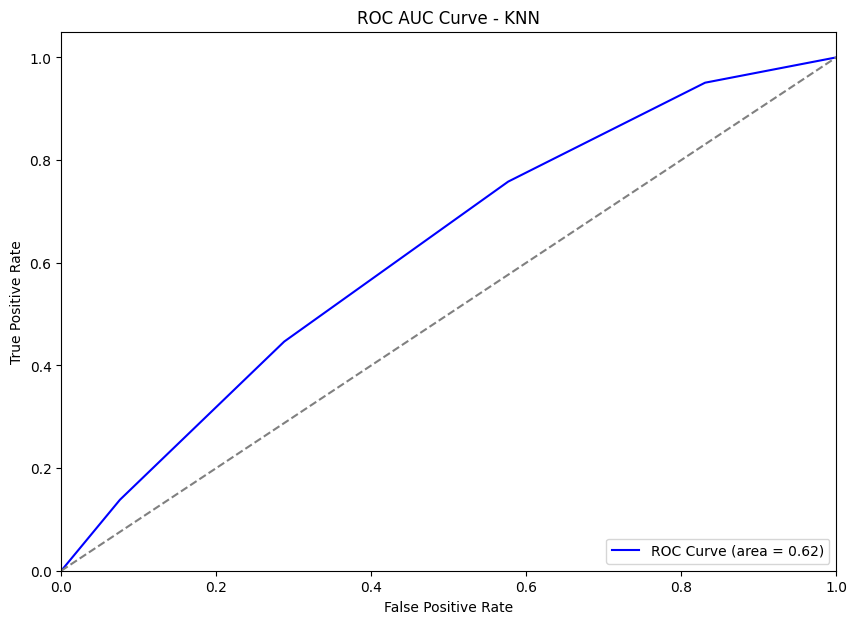

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['n_estimators'] = 600
params['learning_rate'] = 0.02
params['max_depth'] = 7

xgb_clf = XGBClassifier(**params)
gnb_clf = GaussianNB()
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=4)
print("F/T Model")
tryModel(X_trainFT, y_trainFT, X_testFT, y_testFT, xgb_clf, "XGB")
tryModel(X_trainFT, y_trainFT, X_testFT, y_testFT, gnb_clf, "Naive Bayes")
tryModel(X_trainFT, y_trainFT, X_testFT, y_testFT, rf_clf, "Random forest")
tryModel(X_trainFT, y_trainFT, X_testFT, y_testFT, lr_clf, "Logistic regression")
tryModel(X_trainFT, y_trainFT, X_testFT, y_testFT, knn_clf, "KNN")

F/T Model
XGB

Accuracy: 0.657415546904433

Classification Report:
              precision    recall  f1-score   support

         0.0       0.67      0.53      0.60      7537
         1.0       0.65      0.77      0.70      8389

    accuracy                           0.66     15926
   macro avg       0.66      0.65      0.65     15926
weighted avg       0.66      0.66      0.65     15926



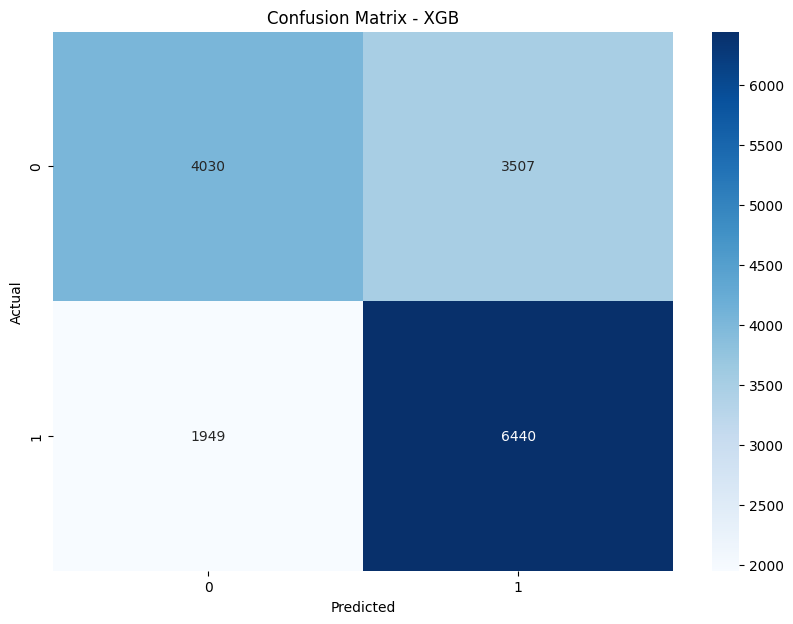

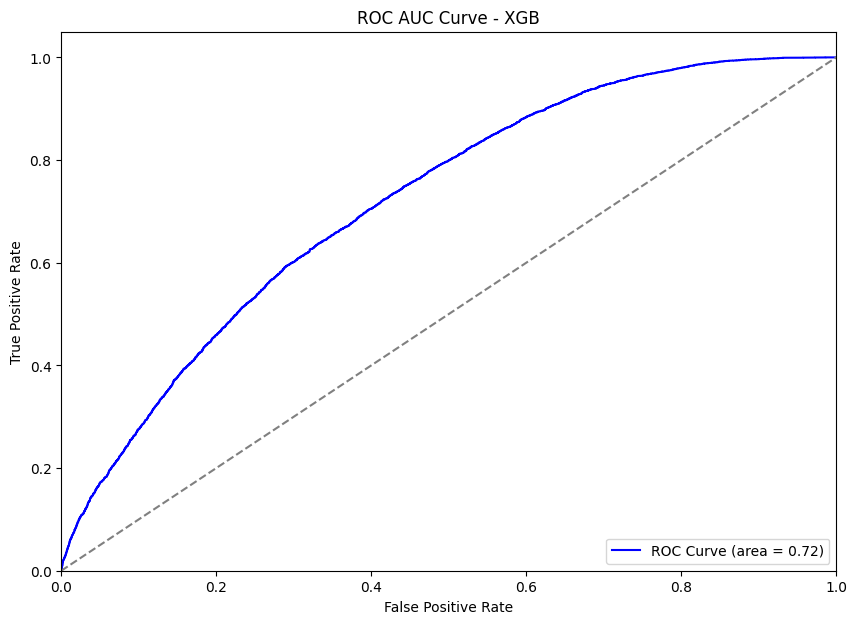

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['n_estimators'] = 600
params['learning_rate'] = 0.02
params['max_depth'] = 7

xgb_clf = XGBClassifier(**params)
print("F/T Model")
tryModel(X_trainFT, y_trainFT, X_testFT, y_testFT, xgb_clf, "XGB")

In [ ]:
modelFT = xgb_clf
filename="/content/drive/MyDrive/Диплом/Colab notebooks/trained_FT.sav"
pickle.dump(modelFT, open(filename,"wb"))

J/P

F/T Model
XGB

Accuracy: 0.5829461258319729

Classification Report:
              precision    recall  f1-score   support

         0.0       0.60      0.53      0.56      8084
         1.0       0.57      0.64      0.60      7842

    accuracy                           0.58     15926
   macro avg       0.58      0.58      0.58     15926
weighted avg       0.59      0.58      0.58     15926



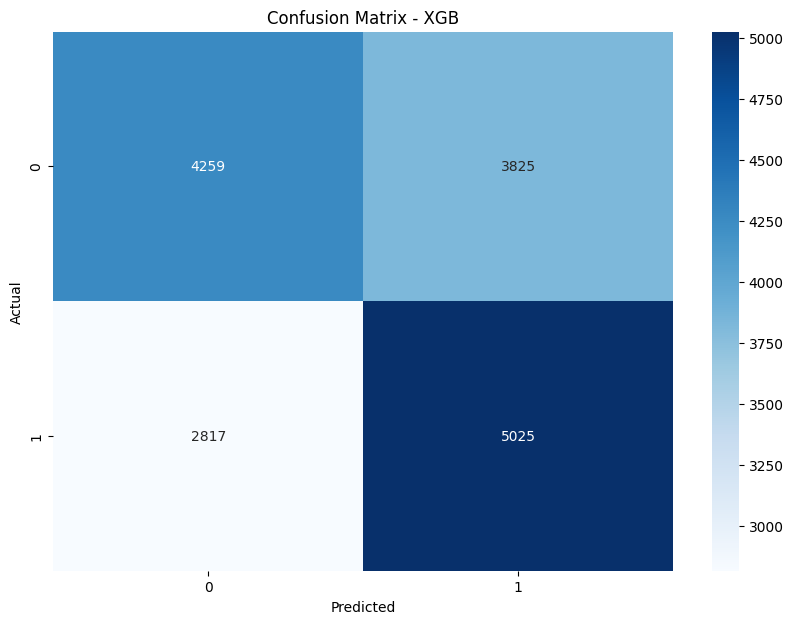

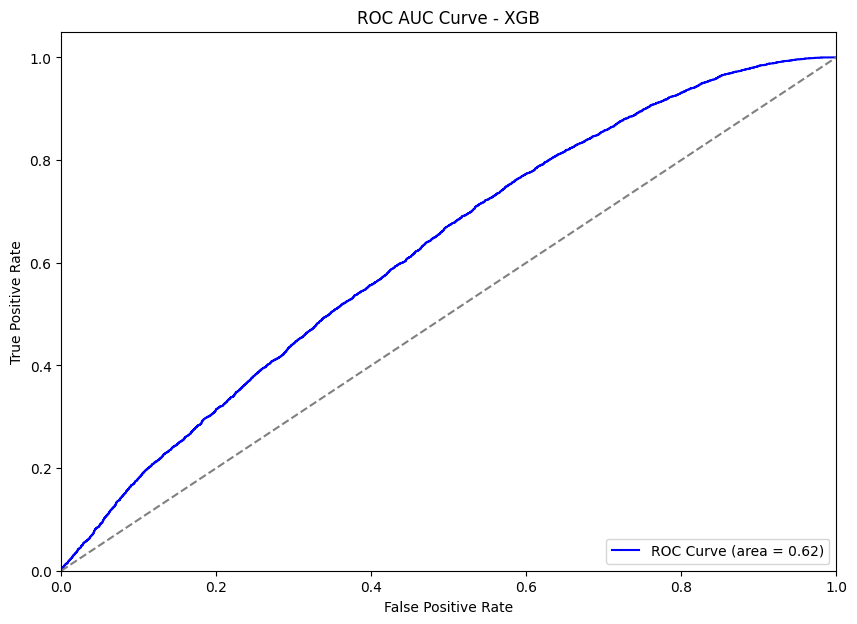



Naive Bayes

Accuracy: 0.5529951023483611

Classification Report:
              precision    recall  f1-score   support

         0.0       0.58      0.45      0.50      8084
         1.0       0.54      0.66      0.59      7842

    accuracy                           0.55     15926
   macro avg       0.56      0.55      0.55     15926
weighted avg       0.56      0.55      0.55     15926



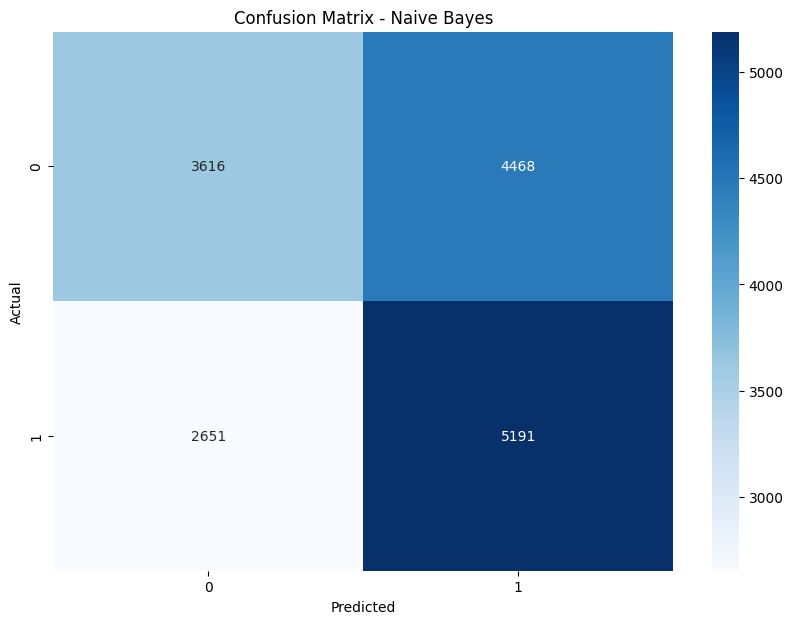

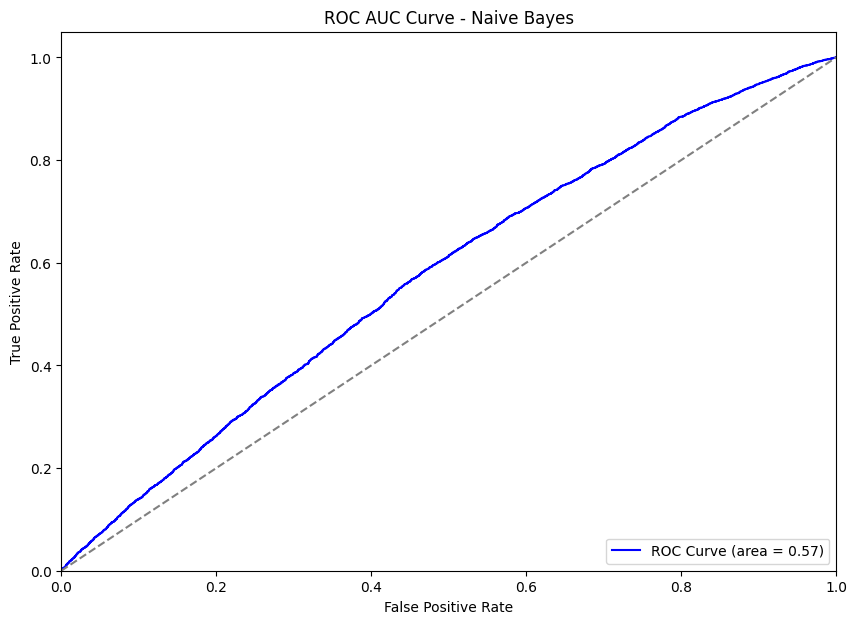



Random forest

Accuracy: 0.5653020218510612

Classification Report:
              precision    recall  f1-score   support

         0.0       0.57      0.57      0.57      8084
         1.0       0.56      0.56      0.56      7842

    accuracy                           0.57     15926
   macro avg       0.57      0.57      0.57     15926
weighted avg       0.57      0.57      0.57     15926



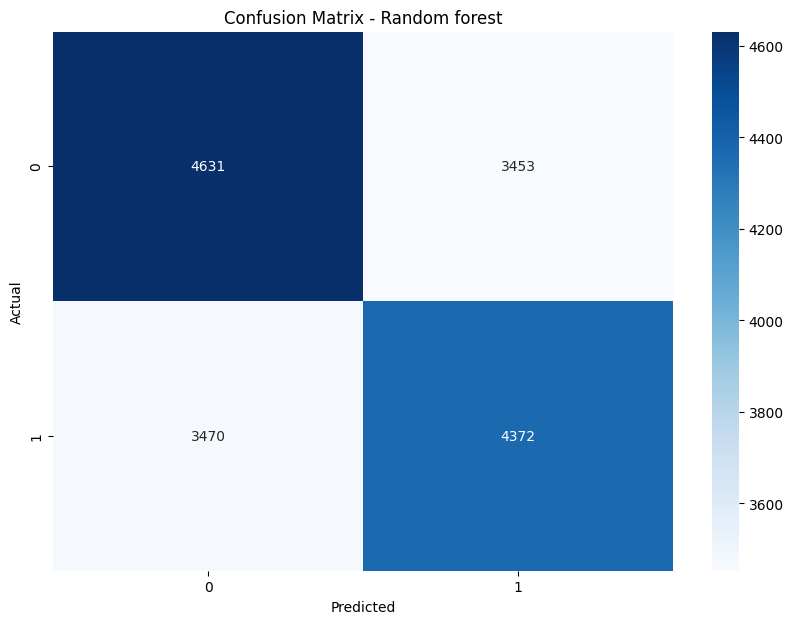

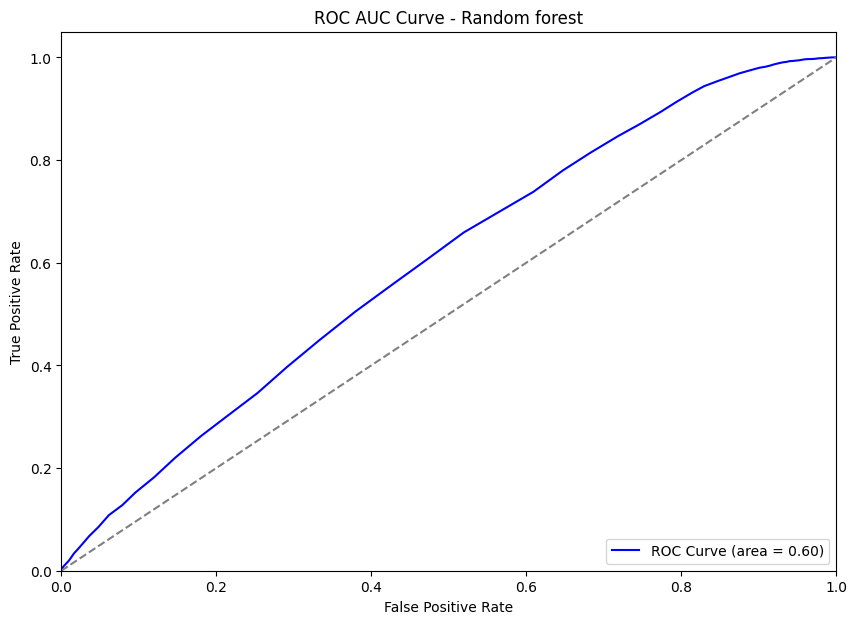



Logistic regression


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Accuracy: 0.5792414919000377

Classification Report:
              precision    recall  f1-score   support

         0.0       0.59      0.54      0.56      8084
         1.0       0.57      0.62      0.59      7842

    accuracy                           0.58     15926
   macro avg       0.58      0.58      0.58     15926
weighted avg       0.58      0.58      0.58     15926



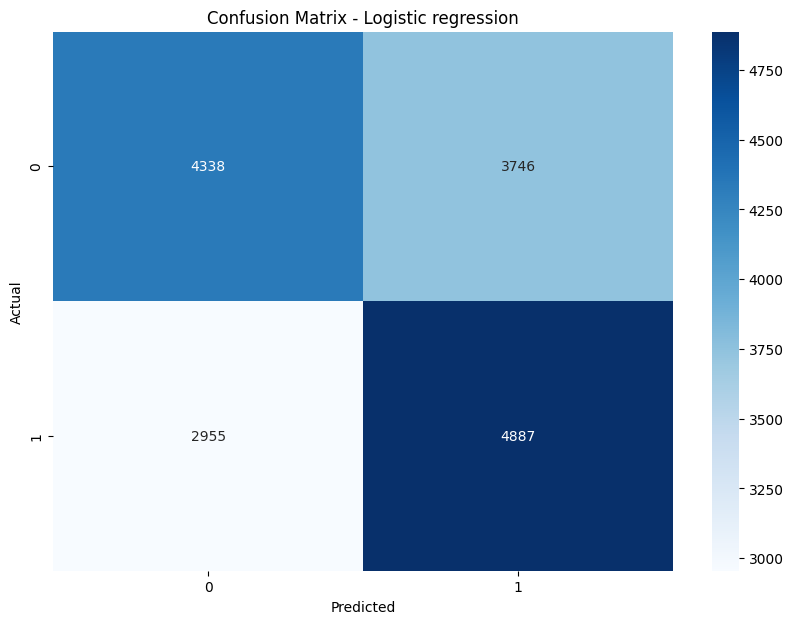

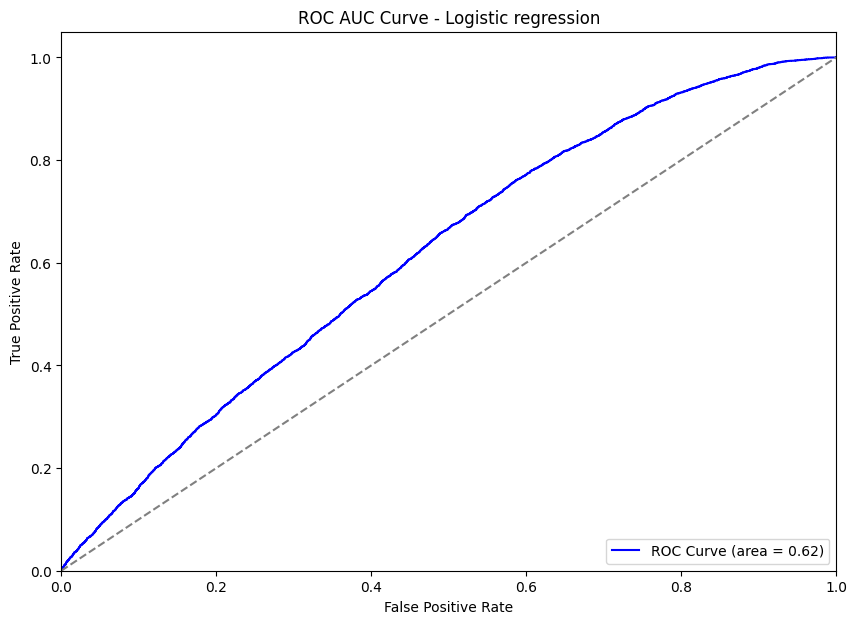



KNN

Accuracy: 0.5402486500062791

Classification Report:
              precision    recall  f1-score   support

         0.0       0.54      0.67      0.60      8084
         1.0       0.54      0.41      0.46      7842

    accuracy                           0.54     15926
   macro avg       0.54      0.54      0.53     15926
weighted avg       0.54      0.54      0.53     15926



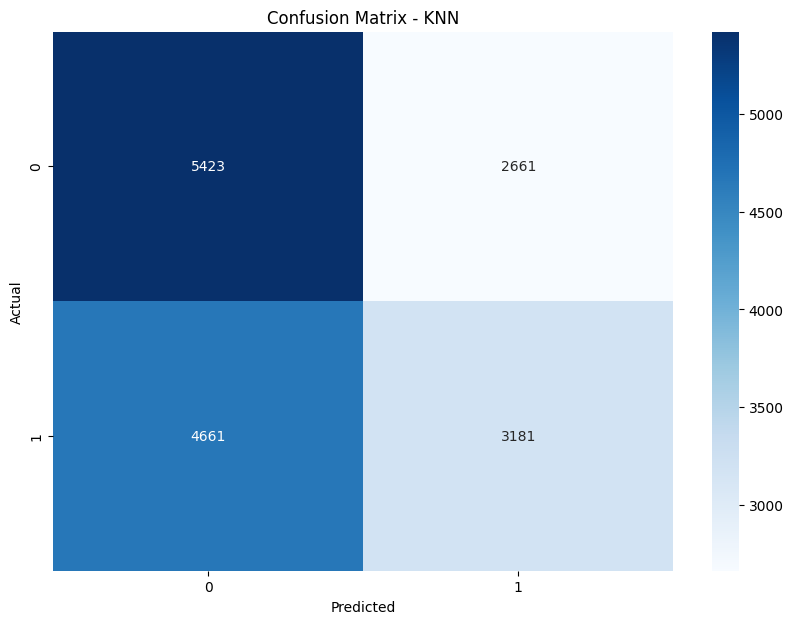

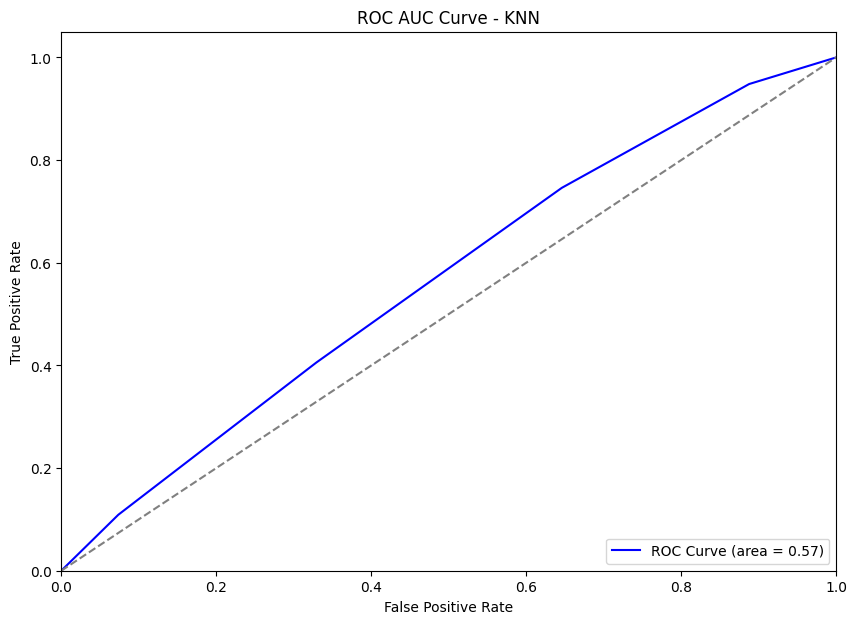

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['n_estimators'] = 600
params['learning_rate'] = 0.02
params['max_depth'] = 7

xgb_clf = XGBClassifier(**params)
gnb_clf = GaussianNB()
rf_clf = RandomForestClassifier()
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=4)
print("F/T Model")
tryModel(X_trainJP, y_trainJP, X_testJP, y_testJP, xgb_clf, "XGB")
tryModel(X_trainJP, y_trainJP, X_testJP, y_testJP, gnb_clf, "Naive Bayes")
tryModel(X_trainJP, y_trainJP, X_testJP, y_testJP, rf_clf, "Random forest")
tryModel(X_trainJP, y_trainJP, X_testJP, y_testJP, lr_clf, "Logistic regression")
tryModel(X_trainJP, y_trainJP, X_testJP, y_testJP, knn_clf, "KNN")

J/P Model
XGB

Accuracy: 0.6011553434635187

Classification Report:
              precision    recall  f1-score   support

         0.0       0.62      0.55      0.58      8061
         1.0       0.59      0.65      0.62      7865

    accuracy                           0.60     15926
   macro avg       0.60      0.60      0.60     15926
weighted avg       0.60      0.60      0.60     15926



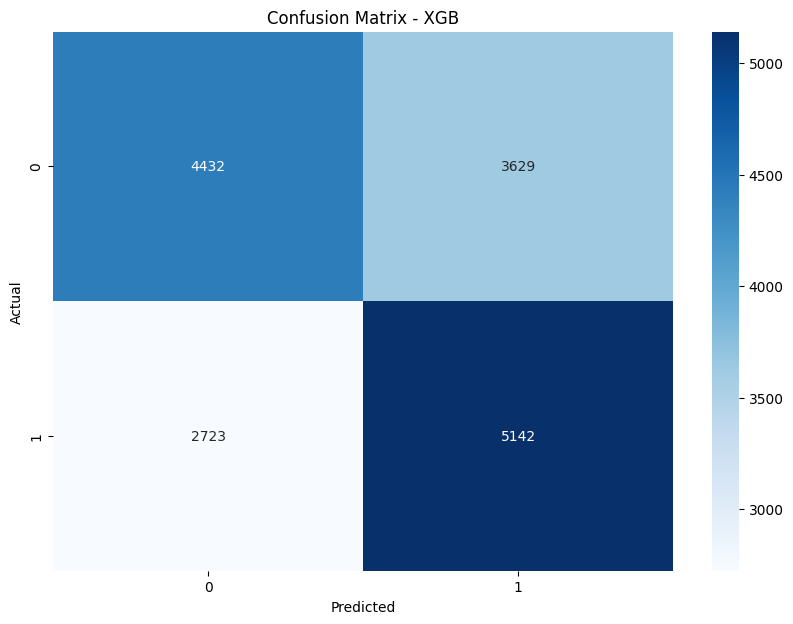

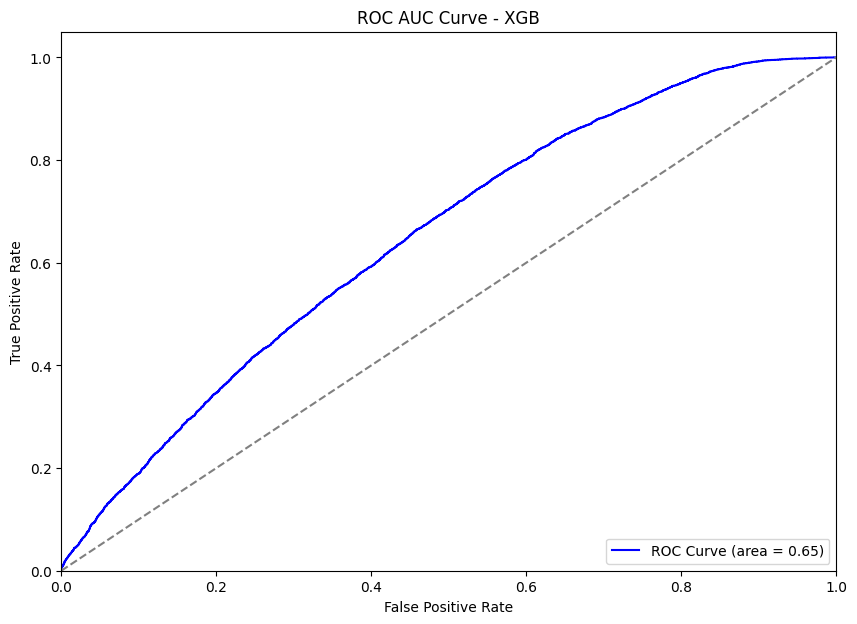

In [ ]:
params = {}
params['objective'] = 'binary:logistic'
params['n_estimators'] = 600
params['learning_rate'] = 0.02
params['max_depth'] = 7

xgb_clf = XGBClassifier(**params)
print("J/P Model")
tryModel(X_trainJP, y_trainJP, X_testJP, y_testJP, xgb_clf, "XGB")

In [ ]:
modelJP = xgb_clf
filename="/content/drive/MyDrive/Диплом/Colab notebooks/trained_JP.sav"
pickle.dump(modelJP, open(filename,"wb"))

**Тестирование**

In [ ]:
%pip install spacy
%pip install textacy
%pip install contractions
%pip install emoji

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 43.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 320.4/320.4 kB 37.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 62.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 17.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 431.4/431.4 kB 7.9 MB/s eta 0:00:00


In [ ]:
import pickle
from emoji import demojize
import contractions
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize
import spacy
import textacy
from textacy import text_stats as ts
from textacy import preprocessing as prep
import re
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import spacy.cli
spacy.cli.download("en_core_web_lg")
drive.mount('/content/drive/')

✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_lg')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.
Mounted at /content/drive/


In [ ]:
# загрузка
filenameIE = "/content/drive/MyDrive/Диплом/Colab notebooks/trained_IE.sav"
with open(filenameIE, "rb") as file:
    loaded_modelIE = pickle.load(file)

filenameNS = "/content/drive/MyDrive/Диплом/Colab notebooks/trained_NS.sav"
with open(filenameNS, "rb") as file:
    loaded_modelNS = pickle.load(file)

filenameFT = "/content/drive/MyDrive/Диплом/Colab notebooks/trained_FT.sav"
with open(filenameFT, "rb") as file:
    loaded_modelFT = pickle.load(file)

filenameJP = "/content/drive/MyDrive/Диплом/Colab notebooks/trained_JP.sav"
with open(filenameJP, "rb") as file:
    loaded_modelJP = pickle.load(file)

In [ ]:
# очистка

def replace_mbti(text):
    mbti_types = [
    'INTJ', 'INTP', 'ENTJ', 'ENTP',
    'INFJ', 'INFP', 'ENFJ', 'ENFP',
    'ISTJ', 'ISFJ', 'ESTJ', 'ESFJ',
    'ISTP', 'ISFP', 'ESTP', 'ESFP',
    'INTJS', 'INTPS', 'ENTJS', 'ENTPS',
    'INFJS', 'INFPS', 'ENFJS', 'ENFPS',
    'ISTJS', 'ISFJS', 'ESTJS', 'ESFJS',
    'ISTPS', 'ISFPS', 'ESTPS', 'ESFPS']
    mbti_pattern = '|'.join(mbti_types)
    pattern = re.compile(r'\b(' + mbti_pattern + r')\b', re.IGNORECASE)
    replaced_text = pattern.sub('MBTI', text)
    return replaced_text

def replace_emojis_with_words(text):
    text = demojize(text, delimiters=(" ", " "))
    text = text.replace(":", "").replace("_", " ")
    return text

def create_preprocessing_pipeline():
    preprocessing_functions = [
        prep.normalize.unicode,
        prep.normalize.bullet_points,
        prep.normalize.hyphenated_words,
        prep.normalize.quotation_marks,
        prep.normalize.whitespace,
        prep.remove.accents,
        prep.remove.brackets,
        prep.remove.html_tags,
        prep.replace.urls,
        prep.replace.user_handles,
        prep.remove.punctuation,
        prep.replace.currency_symbols,
        prep.replace.emails,
        prep.replace.hashtags,
        prep.replace.numbers,
        prep.replace.phone_numbers,
        replace_mbti,
        replace_emojis_with_words,]

    preprocessing_pipeline = prep.pipeline.make_pipeline(*preprocessing_functions)
    return preprocessing_pipeline

nlp = spacy.load("en_core_web_sm")

def clean_text(input_text):
  cleaned_tokens = []
  try:
    input_text = re.sub(r'\|', '', input_text)
    input_text = contractions.fix(input_text)
    pipeline = create_preprocessing_pipeline()
    input_text = pipeline(input_text).lower()
    input_text = re.sub(r'\W+', ' ', input_text)

    doc = nlp(input_text)

    for token in doc:
          # тут очищаем ещё  от стоп-слов и для вектора используем cleaned_tokens
          if not (token.is_punct or token.is_space or token.is_stop or token.is_digit):
              cleaned_tokens.append(token.lemma_)
  except Exception as e:
    print(input_text)
    print(e)
  return ' '.join(cleaned_tokens)

In [ ]:
sample_text = "Hello! I am so excited to be here with u today. We will share many good moments together, I really believe that, so let's not waste any time"
sample_text = clean_text(sample_text)
print(sample_text)

data = pd.DataFrame({'cleaned_text': [sample_text]})

hello excited today share good moment believe let waste time


In [ ]:
# векторизация
nlp = spacy.load("en_core_web_lg")

data['vector'] = data['cleaned_text'].apply(lambda text: nlp(text).vector)
#data['vector'] = data['vector'].apply(lambda x: list(map(float, x.strip('[]').split())))
#data['vector'] = data['vector'].apply(lambda x: np.array(x, dtype=object))

keep_features = []
vector_2d = np.array([vec for vec in data['vector']])
#keep_features = data[keep_features].values
#combined_features = np.hstack((vector_2d, keep_features))
X_data = vector_2d

In [ ]:
predIE = loaded_modelIE.predict(X_data)
predNS = loaded_modelNS.predict(X_data)
predFT = loaded_modelFT.predict(X_data)
predJP = loaded_modelJP.predict(X_data)

predIE = "I" if predIE[0] == 1 else "E"
predNS = "N" if predNS[0] == 1 else "S"
predFT = "F" if predFT[0] == 1 else "T"
predJP = "J" if predJP[0] == 1 else "P"
predictions = predIE + predNS + predFT + predJP
print(predictions) # 1 - F, 0 - T

ENFP
